In [1]:
### Import Packages
import os
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

### Read Files

In [2]:
### Read All files in a directory that contain "RESULTS" substring.

# Function to read all CSV files containing "RESULTS" in filename from a directory and its subdirectories
def read_csv_files(directory):
    all_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if "RESULTS" in file and file.endswith(".csv"):
                all_files.append(os.path.join(root, file))
    
    # Combine all CSV files into one DataFrame
    combined_df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)
    return combined_df

# Example usage
directory_path = './DATA/output/dataset2'
combined_df = read_csv_files(directory_path)


combined_df#.head()

question  \
0     How do LLMs' attention limits affect their rol...   
1     What is the performance of PENTESTGPT in the p...   
2     How do auto-grade MCUs and remote access speed...   
3     How does the critical load shedding threshold ...   
4     How do chosen LLMs fare on pen testing benchma...   
...                                                 ...   
1045  What metrics are used to assess the syntactic ...   
1046  How does pre-decision making contribute to saf...   
1047  How does the availability of source code refle...   
1048  How does the Deep Q-learning with RM algorithm...   
1049  How does GPT-4 perform in completing attack ta...   

                                                 answer  \
0     LLMs, particularly in the context of dynamic s...   
1     In the picoMini CTF competition, PENTESTGPT ma...   
2     Auto-grade MCUs and remote access speed up ECU...   
3     The critical load shedding threshold is crucia...   
4     The chosen LLMs, GPT-3.5, GPT-4, and Bard, wer...   
...                                                 ...   
1045  The metrics used to assess the syntactic quali...   
1046  Pre-decision making contributes to safeguardin...   
1047  Based on the provided context, it appears that...   
1048  Deep Q-Learning with Reward Machine Algorithm ...   
1049  Based on the provided context, GPT-4 performs ...   

                                               contexts  \
0     ['operations. We then execute the suggested op...   
1     ['benchmarks. For this analysis, we deploy PEN...   
2     ['[46] Jungwoo Ryoo, Syed Rizvi, William Aiken...   
3     ['Fig. 4. Proposed state-action-joint security...   
4     ['tion testing benchmark, encompassing a multi...   
...                                                 ...   
1045  ['field, poses a potential threat to construct...   
1046  ['1\nMake Safe Decisions in Power System: Safe...   
1047  ['Not Specified. The lack of clear licensing i...   
1048  ['Event Description\n‘a’\nDiscovered new nodes...   
1049  ['GPT-4\nExcalibur\nFigure 7: Penetration test...   

                                           ground_truth                model  \
0     LLMs typically lack situational awareness, whi...  lucataco/qwen1.5-7b   
1     PENTESTGPT's performance in the picoMini CTF c...  lucataco/qwen1.5-7b   
2     Auto-grade MCUs and remote access speed up ECU...  lucataco/qwen1.5-7b   
3     The critical load shedding threshold is the mi...  lucataco/qwen1.5-7b   
4     The chosen LLMs demonstrate proficiency in man...  lucataco/qwen1.5-7b   
...                                                 ...                  ...   
1045  The metrics used to assess the syntactic quali...    01-ai/yi-34b-chat   
1046  Pre-decision making contributes to safeguardin...    01-ai/yi-34b-chat   
1047  The availability of source code for more than ...    01-ai/yi-34b-chat   
1048  The Deep Q-learning with RM algorithm (DQRM) t...    01-ai/yi-34b-chat   
1049  GPT-4 achieves a perfect success rate in compl...    01-ai/yi-34b-chat   

      context_precision  faithfulness  answer_relevancy  context_recall  \
0                   1.0      0.800000          0.766865             1.0   
1                   0.0      1.000000          0.829607             0.5   
2                   0.0      0.000000          1.000000             0.0   
3                   1.0      0.857143          0.691835             1.0   
4                   0.5      0.666667          0.000000             0.0   
...                 ...           ...               ...             ...   
1045                0.5      1.000000          1.000000             1.0   
1046                1.0      0.571429          1.000000             1.0   
1047                1.0      0.285714          0.845078             1.0   
1048                1.0      0.352941          0.874197             1.0   
1049                0.0      0.857143          0.769996             0.0   

      answer_correctness  answer_similarity  
0           

In [3]:
combined_df['contexts'] = combined_df['contexts'].apply(eval)
combined_df['concatenated_contexts'] = combined_df['contexts'].apply(lambda x: ' '.join(x))

In [4]:
#combined_df["ground_truth"]

In [10]:
len(combined_df)

1050

In [12]:
len(combined_df.dropna())

919

### Drop no-answer rows

In [13]:
combined_df = combined_df.dropna()

### Calculate BLEU, BLEU_Score and ROUGUE_Score

In [14]:
# %pip install rouge
# %pip install bert_score

In [15]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
from bert_score import score

# Assuming your dataframe is named 'df'

# Function to calculate BLEU score
def calculate_bleu(reference, candidate):
    #print(candidate)
    smoothie = SmoothingFunction().method1
    return sentence_bleu([reference.split()], candidate.split(),
                        weights=(0.25, 0.25, 0.25, 0.25),  # This gives equal weight to 1, 2, 3, and 4-grams
                        smoothing_function=smoothie
                        )

# Function to calculate ROUGE scores
def calculate_rouge(reference, candidate):
    rouge = Rouge()
    scores = rouge.get_scores(candidate, reference)
    return scores[0]['rouge-l']['f']  # Using ROUGE-L F1 score


def calculate_bertscore(references, candidates):
    P, R, F1 = score(candidates, references, lang="en", verbose=False)
    return F1.tolist()  # Return F1 scores as a list

# Apply the functions to create new columns
combined_df['BLEUScore'] = combined_df.apply(lambda row: calculate_bleu(row['ground_truth'], row['answer']), axis=1)
combined_df['ROUGEScore'] = combined_df.apply(lambda row: calculate_rouge(row['ground_truth'], row['answer']), axis=1)

# Calculate BERTScore
references = combined_df['ground_truth'].tolist()
candidates = combined_df['answer'].tolist()
combined_df['BERTScore'] = calculate_bertscore(references, candidates)


# If you want separate columns for different BLEU scores (e.g., BLEU-1, BLEU-2, etc.),
# you can modify the calculate_bleu function and add more columns accordingly.

# Display the updated dataframe
#combined_df.head()

/tmp/ipykernel_1126150/2483217931.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['BLEUScore'] = combined_df.apply(lambda row: calculate_bleu(row['ground_truth'], row['answer']), axis=1)
/tmp/ipykernel_1126150/2483217931.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['ROUGEScore'] = combined_df.apply(lambda row: calculate_rouge(row['ground_truth'], row['answer']), axis=1)
/home/hamzicd/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torc

In [71]:
combined_df.to_csv("./DATA/output/dataset2/metricsBertBleuRouge.csv", encoding='utf-8', index=False)

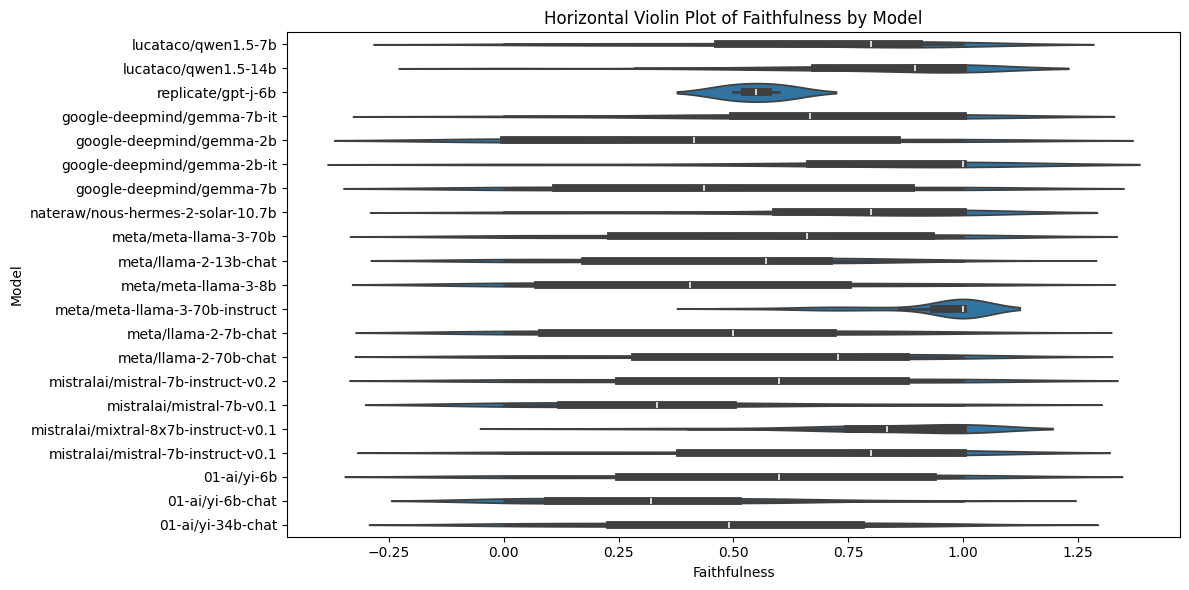

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming combined_df is already available from the previous steps

# Plot horizontal violin plot for faithfulness for each model
plt.figure(figsize=(12, 6))
sns.violinplot(y='model', x='faithfulness', data=combined_df)
plt.title('Horizontal Violin Plot of Faithfulness by Model')
plt.ylabel('Model')
plt.xlabel('Faithfulness')
plt.tight_layout()
plt.show()


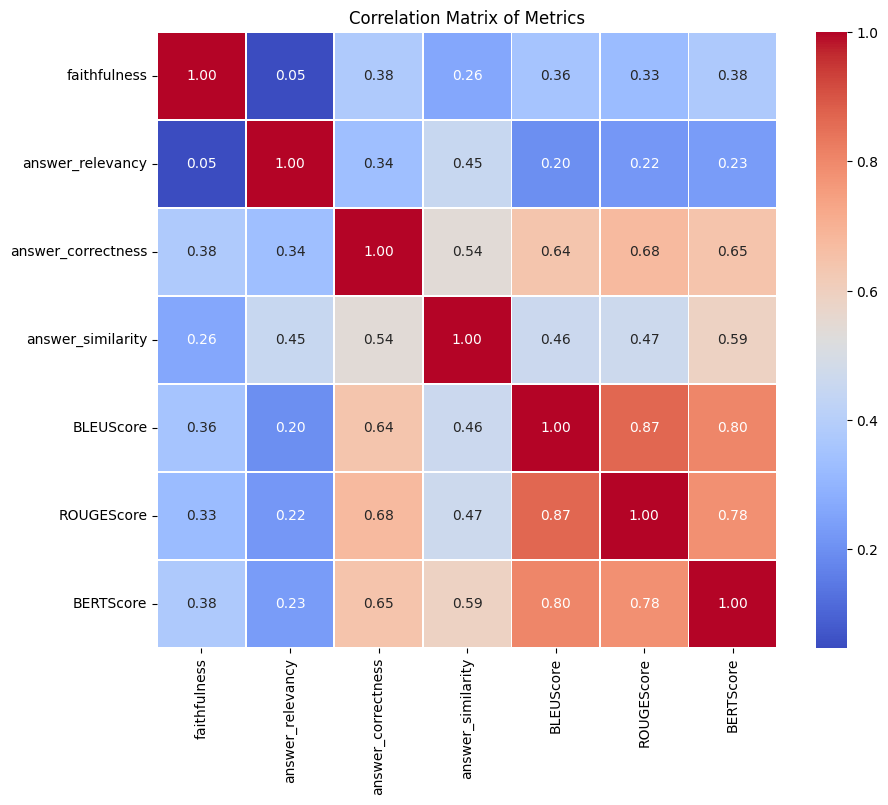

In [17]:
corr_matrix = combined_df[['faithfulness', 'answer_relevancy', 'answer_correctness', 'answer_similarity','BLEUScore', 'ROUGEScore', 'BERTScore']].corr()

# Plotting the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Metrics')
plt.show()

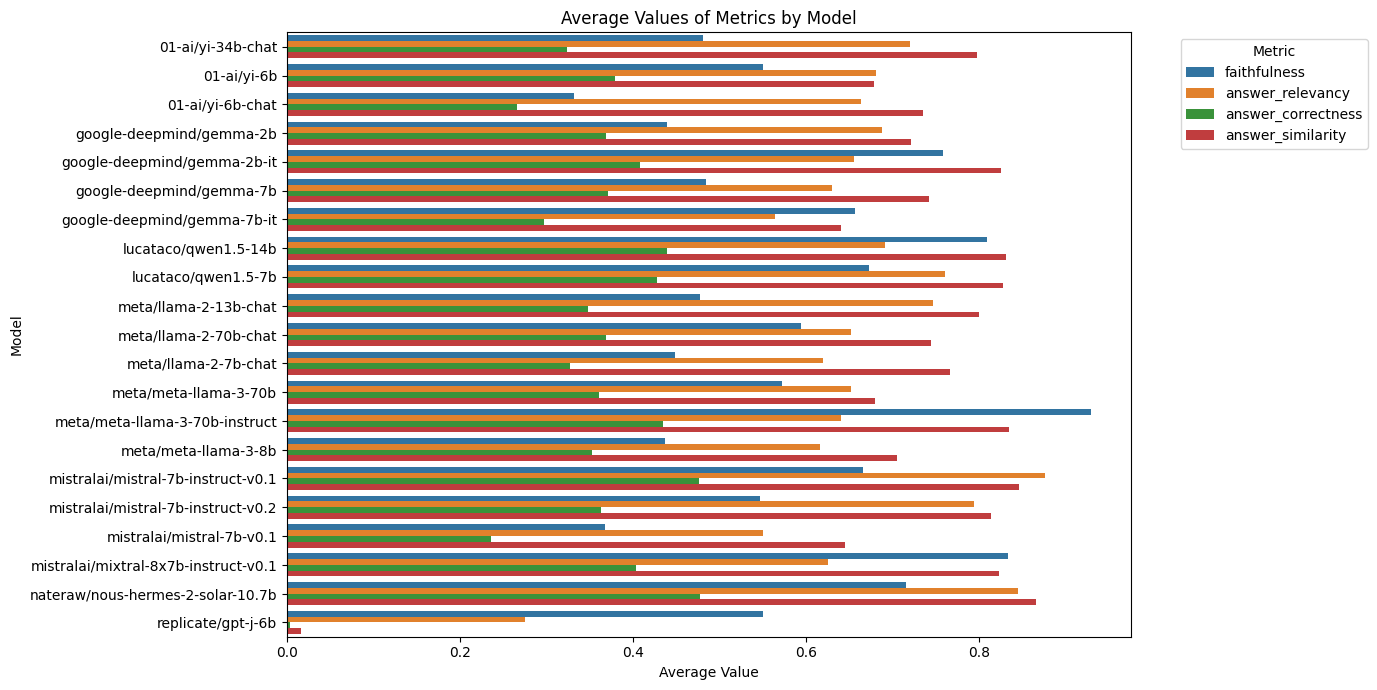

In [18]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[['faithfulness', 'answer_relevancy', 'answer_correctness', 'answer_similarity']].mean().reset_index()

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Plot barplot
plt.figure(figsize=(14, 7))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

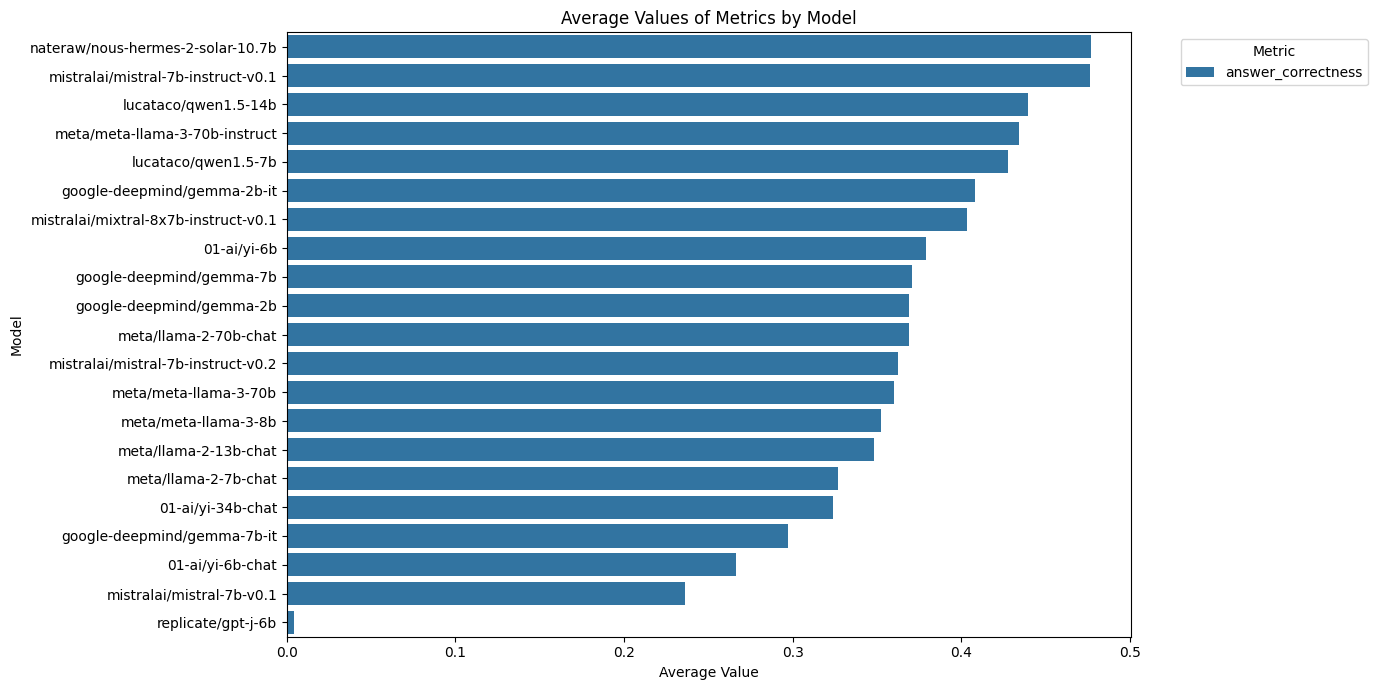

In [19]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[['answer_correctness']].mean().reset_index()
average_df = average_df.sort_values(by='answer_correctness', ascending=False)

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Plot barplot
plt.figure(figsize=(14, 7))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

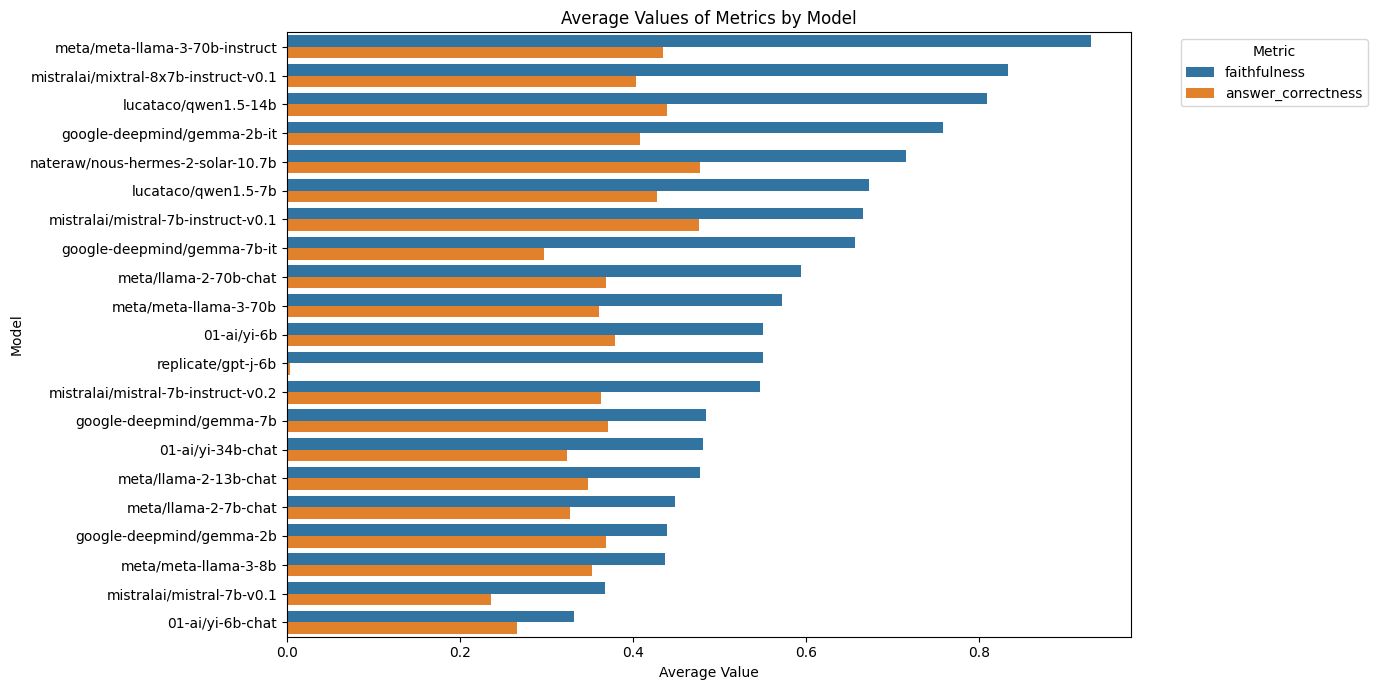

In [51]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[['faithfulness','answer_correctness']].mean().reset_index()
average_df = average_df.sort_values(by='faithfulness', ascending=False)

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Plot barplot
plt.figure(figsize=(14, 7))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[['faithfulness', 'ROUGEScore']].mean().reset_index()
average_df = average_df.sort_values(by='BLEUScore', ascending=False)

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Plot barplot
plt.figure(figsize=(14, 7))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

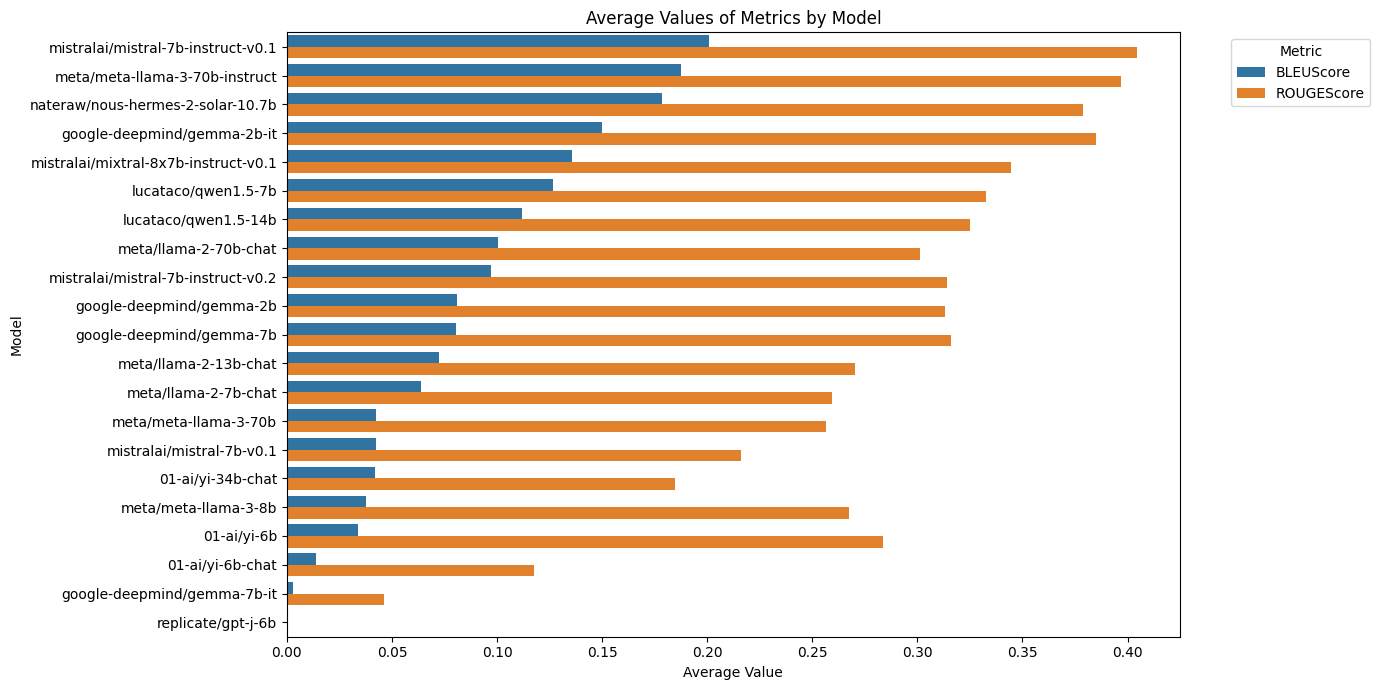

In [20]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[['BLEUScore', 'ROUGEScore']].mean().reset_index()
average_df = average_df.sort_values(by='BLEUScore', ascending=False)

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Plot barplot
plt.figure(figsize=(14, 7))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

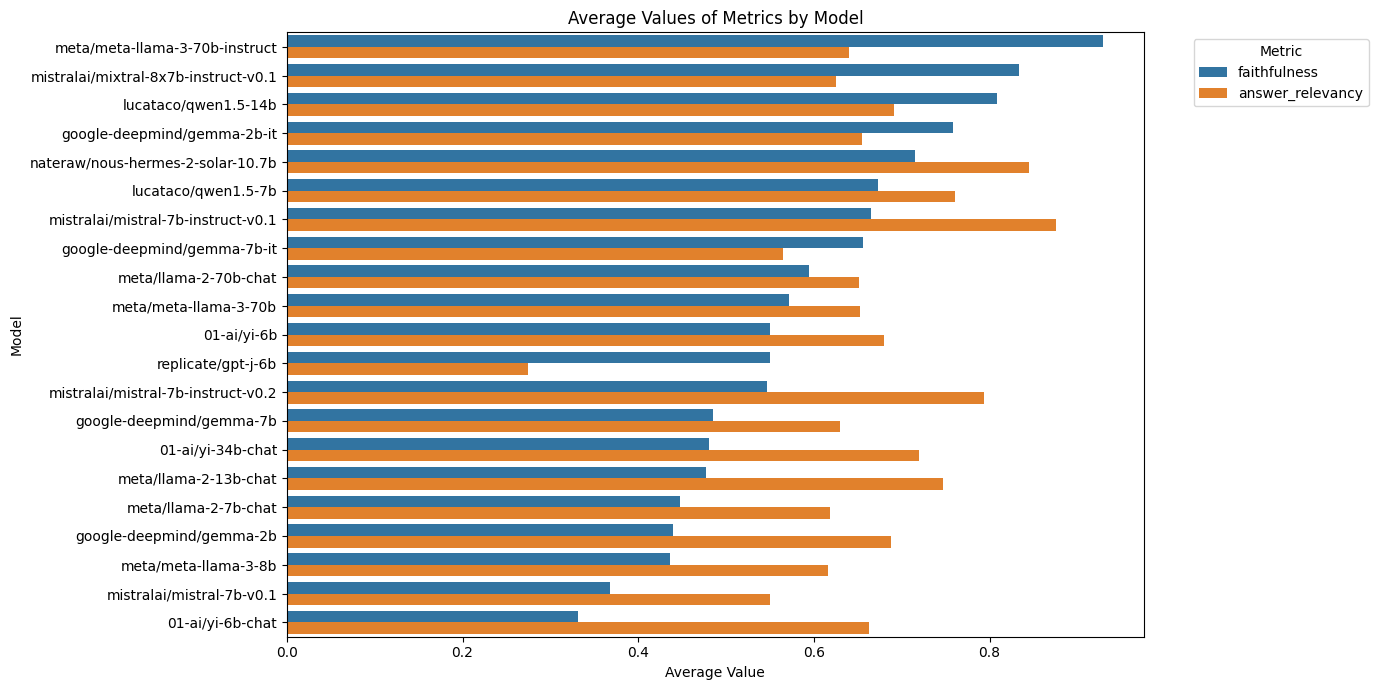

In [43]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[["faithfulness", "answer_relevancy"]].mean().reset_index()
average_df = average_df.sort_values(by='faithfulness', ascending=False)

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Plot barplot
plt.figure(figsize=(14, 7))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

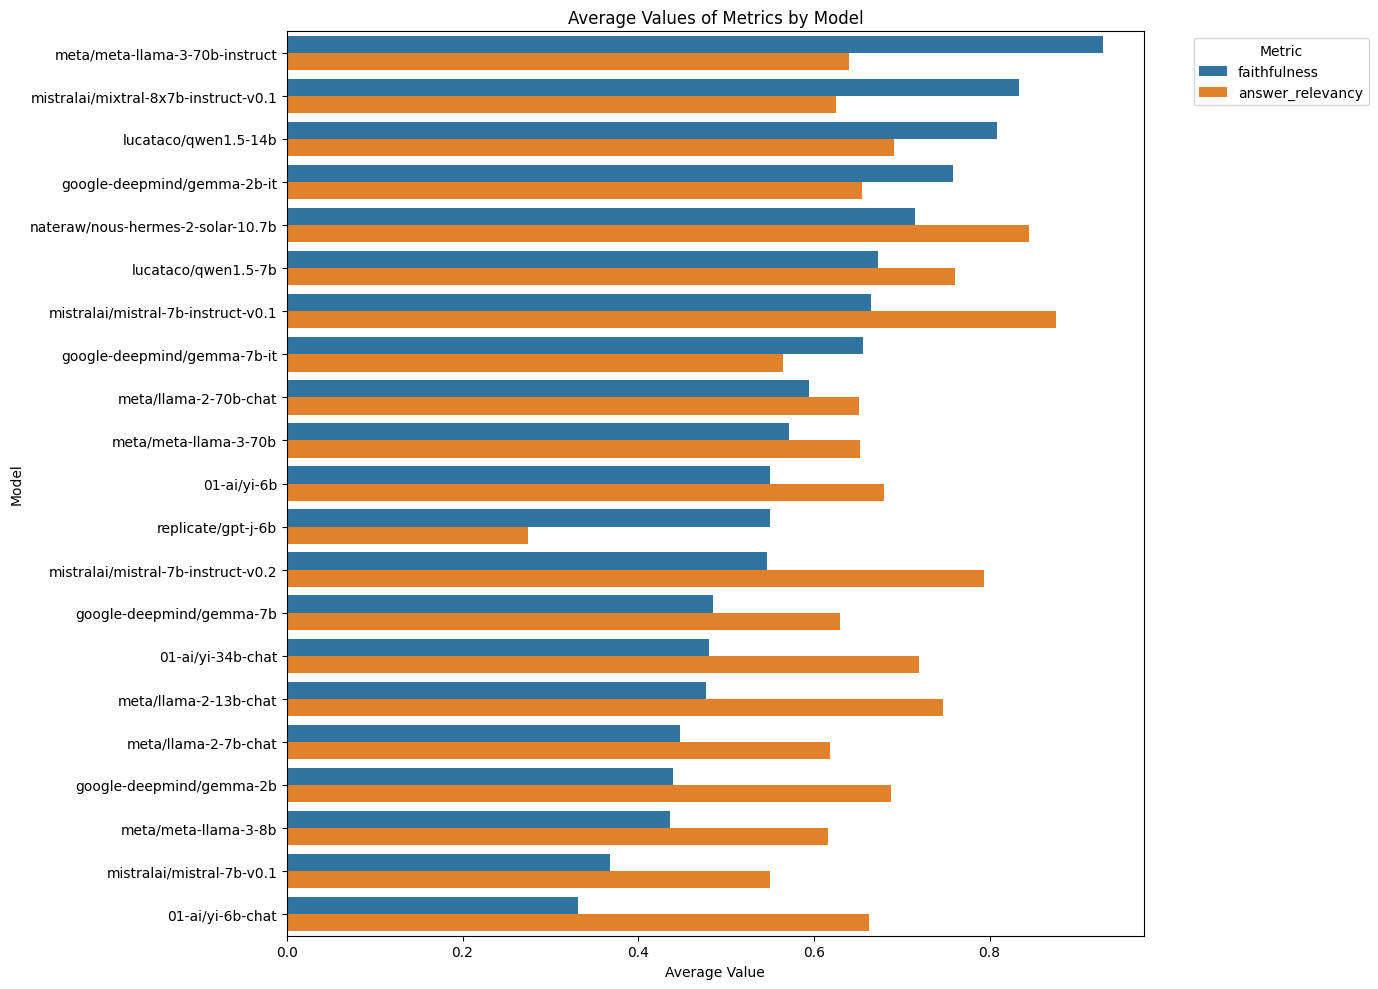

In [22]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[["faithfulness", "answer_relevancy"]].mean().reset_index()
average_df = average_df.sort_values(by='faithfulness', ascending=False)

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Alternative plot using grouped bar plot for better comparison
plt.figure(figsize=(14, 10))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df, dodge=True)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

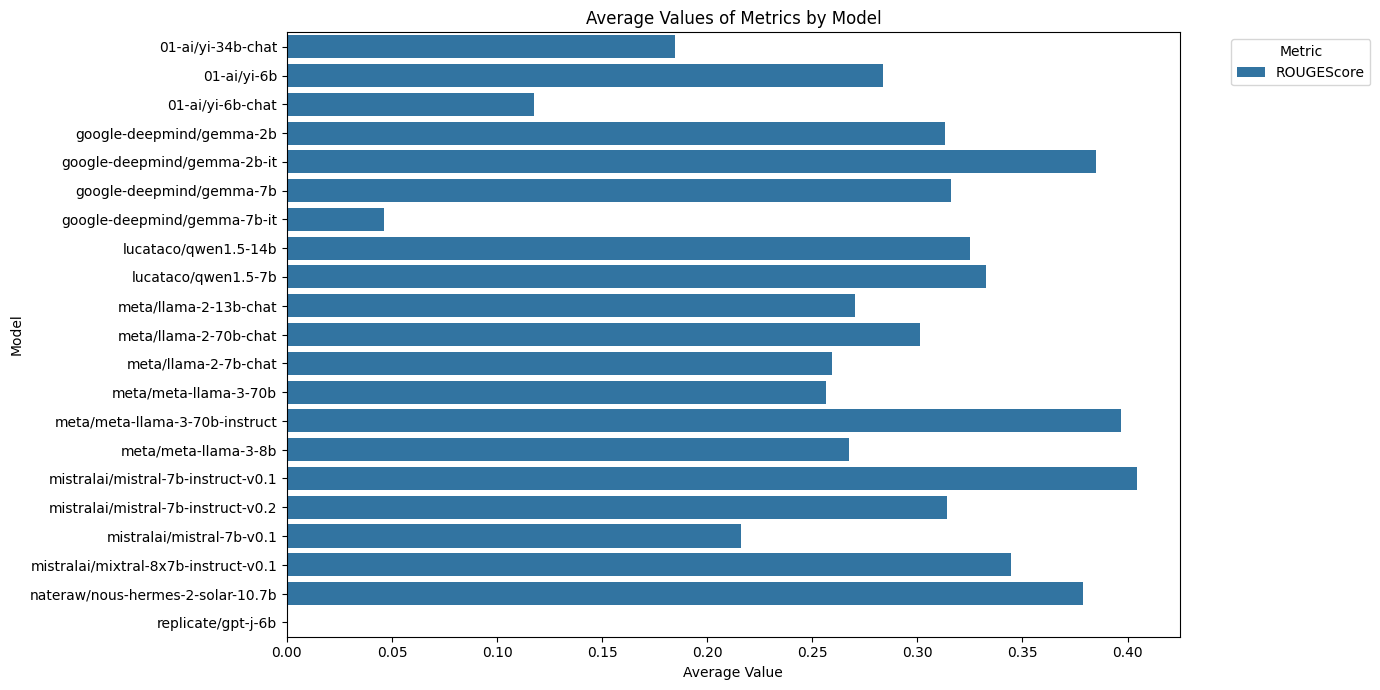

In [23]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[['ROUGEScore']].mean().reset_index()

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Plot barplot
plt.figure(figsize=(14, 7))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

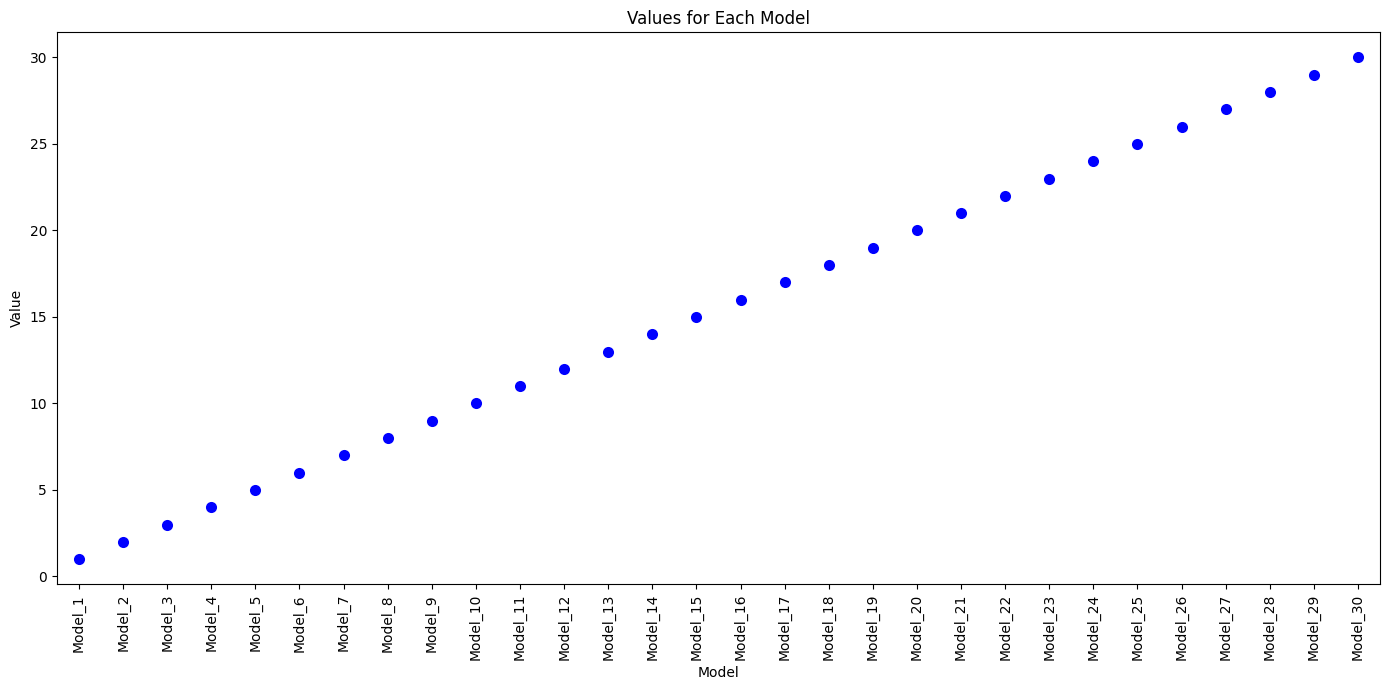

In [24]:
# Sample data creation for demonstration
data = {
    'model': [f'Model_{i}' for i in range(1, 31)],
    'value': [i for i in range(1, 31)]  # Replace with your actual values
}

df = pd.DataFrame(data)

# Plot vertical dot plot
plt.figure(figsize=(14, 7))
sns.stripplot(x='model', y='value', data=df, size=8, color='blue', jitter=False)
plt.title('Values for Each Model')
plt.xlabel('Model')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [25]:
#combined_df

In [26]:
combined_df.groupby('model')[['faithfulness', 'answer_relevancy', 'answer_correctness', 'answer_similarity']].mean()

faithfulness  answer_relevancy  \
model                                                                  
01-ai/yi-34b-chat                         0.480877          0.719322   
01-ai/yi-6b                               0.550175          0.680038   
01-ai/yi-6b-chat                          0.331220          0.663054   
google-deepmind/gemma-2b                  0.439558          0.688003   
google-deepmind/gemma-2b-it               0.757843          0.655167   
google-deepmind/gemma-7b                  0.484596          0.629920   
google-deepmind/gemma-7b-it               0.655810          0.564297   
lucataco/qwen1.5-14b                      0.809021          0.691472   
lucataco/qwen1.5-7b                       0.672658          0.760178   
meta/llama-2-13b-chat                     0.477413          0.746465   
meta/llama-2-70b-chat                     0.593958          0.651912   
meta/llama-2-7b-chat                      0.447794          0.618774   
meta/meta-llama-3-70b                     0.571543          0.652246   
meta/meta-llama-3-70b-instruct            0.929193          0.640306   
meta/meta-llama-3-8b                      0.436381          0.615669   
mistralai/mistral-7b-instruct-v0.1        0.665079          0.875687   
mistralai/mistral-7b-instruct-v0.2        0.546210          0.793255   
mistralai/mistral-7b-v0.1                 0.367937          0.550233   
mistralai/mixtral-8x7b-instruct-v0.1      0.833260          0.624648   
nateraw/nous-hermes-2-solar-10.7b         0.715556          0.845074   
replicate/gpt-j-6b                        0.550000          0.274824   

                                      answer_correctness  answer_similarity  
model                                                                        
01-ai/yi-34b-chat                               0.323959           0.797396  
01-ai/yi-6b                                     0.378909           0.678273  
01-ai/yi-6b-chat                                0.266233           0.735213  
google-deepmind/gemma-2b                        0.369130           0.720924  
google-deepmind/gemma-2b-it                     0.408276           0.825249  
google-deepmind/gemma-7b                        0.371010           0.741620  
google-deepmind/gemma-7b-it                     0.297392           0.640523  
lucataco/qwen1.5-14b                            0.439554           0.830944  
lucataco/qwen1.5-7b                             0.427858           0.827797  
meta/llama-2-13b-chat                           0.348045           0.799775  
meta/llama-2-70b-chat                           0.368725           0.744358  
meta/llama-2-7b-chat                            0.326868           0.766349  
meta/meta-llama-3-70b                           0.360333           0.679490  
meta/meta-llama-3-70b-instruct                  0.434311           0.834571  
meta/meta-llama-3-8b                            0.352124           0.704336  
mistralai/mistral-7b-instruct-v0.1              0.476244           0.845522  
mistralai/mistral-7b-instruct-v0.2              0.362734           0.813467  
mistralai/mistral-7b-v0.1                       0.236071           0.644395  
mistralai/mixtral-8x7b-instruct-v0.1            0.403504           0.822645  
nateraw/nous-hermes-2-solar-10.7b               0.477079           0.864949  
replicate/gpt-j-6b                              0.004027           0.016109

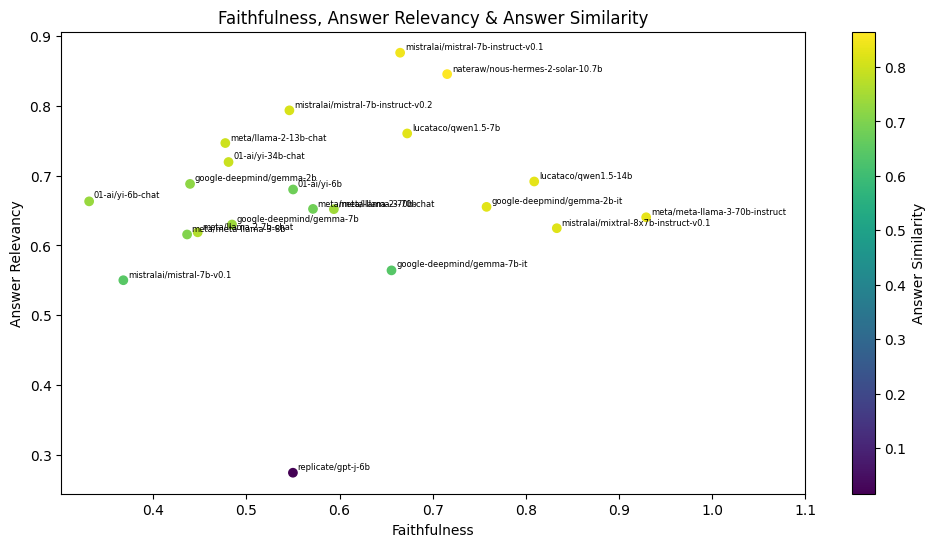

In [27]:
grouped_df = combined_df.groupby('model')[['faithfulness', 'answer_relevancy', 'answer_correctness', 'answer_similarity']].mean()
grouped_df["llm_name"] = grouped_df.index

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter('faithfulness', 'answer_relevancy', c='answer_similarity', cmap='viridis', data=grouped_df)

# Add text labels with a slight offset
offset = 0.005  # Adjust offset value as needed to prevent overlap
for index, row in grouped_df.iterrows():
    ax.text(row['faithfulness'] + offset, row['answer_relevancy'] + offset, row['llm_name'], fontsize=6)

# Set axis labels
ax.set_xlabel('Faithfulness')
ax.set_ylabel('Answer Relevancy')
ax.set_xlim(right=1.1)  # Extend the x-axis limit for better visibility
ax.set_title('Faithfulness, Answer Relevancy & Answer Similarity')

# Create and label the color bar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Answer Similarity')  # Set color bar label



plt.savefig("Faithfulness-vs-Answer-Relevancy-vs-Answer-Similarity.png")
plt.savefig("Faithfulness-vs-Answer-Relevancy-vs-Answer-Similarity.pdf")
# Show plot
plt.show()

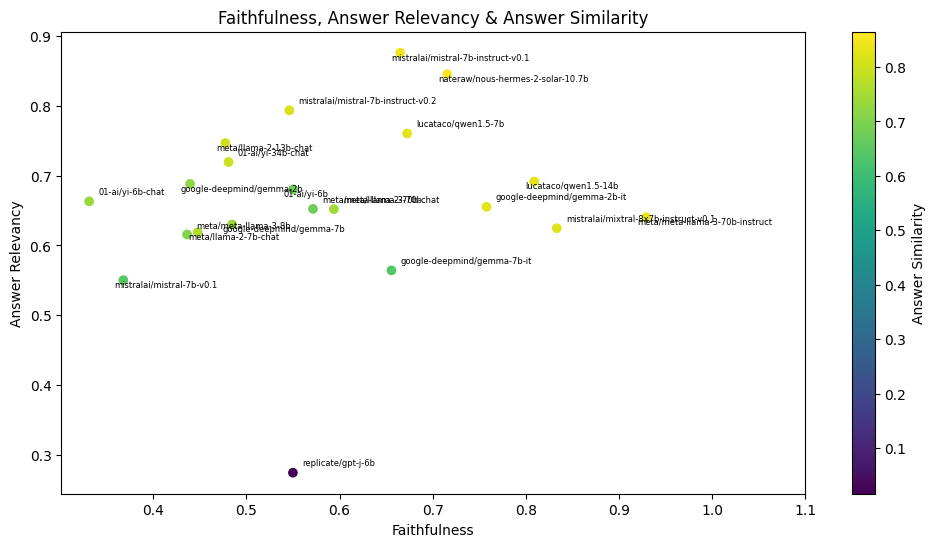

In [28]:
grouped_df = combined_df.groupby('model')[['faithfulness', 'answer_relevancy', 'answer_correctness', 'answer_similarity']].mean()
grouped_df["llm_name"] = grouped_df.index

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter('faithfulness', 'answer_relevancy', c='answer_similarity', cmap='viridis', data=grouped_df)

# Adjust text labels with a slight offset based on index
offset = 0.01  # Adjust offset value as needed to prevent overlap
for i, (index, row) in enumerate(grouped_df.iterrows()):
    # Alternate offsets for better visibility
    if i % 2 == 0:
        ax.text(row['faithfulness'] + offset, row['answer_relevancy'] + offset, row['llm_name'], fontsize=6)
    else:
        ax.text(row['faithfulness'] - offset, row['answer_relevancy'] - offset, row['llm_name'], fontsize=6)

# Set axis labels
ax.set_xlabel('Faithfulness')
ax.set_ylabel('Answer Relevancy')
ax.set_xlim(right=1.1)  # Extend the x-axis limit for better visibility
ax.set_title('Faithfulness, Answer Relevancy & Answer Similarity')

# Create and label the color bar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Answer Similarity')  # Set color bar label

#plt.savefig("/mnt/data/Faithfulness-vs-Answer-Relevancy-vs-Answer-Similarity.png")
#plt.savefig("/mnt/data/Faithfulness-vs-Answer-Relevancy-vs-Answer-Similarity.pdf")
# Show plot
plt.show()

In [29]:
### Extract Metrics
df_metrics1 = combined_df.groupby('model')[['faithfulness', 'answer_relevancy', 'answer_correctness', 'answer_similarity', 'BLEUScore', 'ROUGEScore',	'BERTScore']].mean()
df_metrics1

faithfulness  answer_relevancy  \
model                                                                  
01-ai/yi-34b-chat                         0.480877          0.719322   
01-ai/yi-6b                               0.550175          0.680038   
01-ai/yi-6b-chat                          0.331220          0.663054   
google-deepmind/gemma-2b                  0.439558          0.688003   
google-deepmind/gemma-2b-it               0.757843          0.655167   
google-deepmind/gemma-7b                  0.484596          0.629920   
google-deepmind/gemma-7b-it               0.655810          0.564297   
lucataco/qwen1.5-14b                      0.809021          0.691472   
lucataco/qwen1.5-7b                       0.672658          0.760178   
meta/llama-2-13b-chat                     0.477413          0.746465   
meta/llama-2-70b-chat                     0.593958          0.651912   
meta/llama-2-7b-chat                      0.447794          0.618774   
meta/meta-llama-3-70b                     0.571543          0.652246   
meta/meta-llama-3-70b-instruct            0.929193          0.640306   
meta/meta-llama-3-8b                      0.436381          0.615669   
mistralai/mistral-7b-instruct-v0.1        0.665079          0.875687   
mistralai/mistral-7b-instruct-v0.2        0.546210          0.793255   
mistralai/mistral-7b-v0.1                 0.367937          0.550233   
mistralai/mixtral-8x7b-instruct-v0.1      0.833260          0.624648   
nateraw/nous-hermes-2-solar-10.7b         0.715556          0.845074   
replicate/gpt-j-6b                        0.550000          0.274824   

                                      answer_correctness  answer_similarity  \
model                                                                         
01-ai/yi-34b-chat                               0.323959           0.797396   
01-ai/yi-6b                                     0.378909           0.678273   
01-ai/yi-6b-chat                                0.266233           0.735213   
google-deepmind/gemma-2b                        0.369130           0.720924   
google-deepmind/gemma-2b-it                     0.408276           0.825249   
google-deepmind/gemma-7b                        0.371010           0.741620   
google-deepmind/gemma-7b-it                     0.297392           0.640523   
lucataco/qwen1.5-14b                            0.439554           0.830944   
lucataco/qwen1.5-7b                             0.427858           0.827797   
meta/llama-2-13b-chat                           0.348045           0.799775   
meta/llama-2-70b-chat                           0.368725           0.744358   
meta/llama-2-7b-chat                            0.326868           0.766349   
meta/meta-llama-3-70b                           0.360333           0.679490   
meta/meta-llama-3-70b-instruct                  0.434311           0.834571   
meta/meta-llama-3-8b                            0.352124           0.704336   
mistralai/mistral-7b-instruct-v0.1              0.476244           0.845522   
mistralai/mistral-7b-instruct-v0.2              0.362734           0.813467   
mistralai/mistral-7b-v0.1                       0.236071           0.644395   
mistralai/mixtral-8x7b-instruct-v0.1            0.403504           0.822645   
nateraw/nous-hermes-2-solar-10.7b               0.477079           0.864949   
replicate/gpt-j-6b                              0.004027           0.016109   

                                      BLEUScore  ROUGEScore  BERTScore  
model                                                                   
01-ai/yi-34b-chat                      0.042056    0.184543   0.851773  
01-ai/yi-6b                            0.033960    0.283533   0.824611  
01-ai/yi-6b-chat                       0.013687    0.117440   0.840040  
google-deepmind/gemma-2b               0.080918    0.313120   0.851956  
google-deepmind/gemma-2b-it            0.150046    0.384796   0.891509  
google-deepmind/gemma-7b               0.080525    0

In [30]:
df_metrics1["Model"] = df_metrics1.index
df_metrics1[['provider','Model']] = df_metrics1['Model'].str.split('/',expand=True)
#df_metrics1.index = df_metrics1["model"]
df_metrics1

faithfulness  answer_relevancy  \
model                                                                  
01-ai/yi-34b-chat                         0.480877          0.719322   
01-ai/yi-6b                               0.550175          0.680038   
01-ai/yi-6b-chat                          0.331220          0.663054   
google-deepmind/gemma-2b                  0.439558          0.688003   
google-deepmind/gemma-2b-it               0.757843          0.655167   
google-deepmind/gemma-7b                  0.484596          0.629920   
google-deepmind/gemma-7b-it               0.655810          0.564297   
lucataco/qwen1.5-14b                      0.809021          0.691472   
lucataco/qwen1.5-7b                       0.672658          0.760178   
meta/llama-2-13b-chat                     0.477413          0.746465   
meta/llama-2-70b-chat                     0.593958          0.651912   
meta/llama-2-7b-chat                      0.447794          0.618774   
meta/meta-llama-3-70b                     0.571543          0.652246   
meta/meta-llama-3-70b-instruct            0.929193          0.640306   
meta/meta-llama-3-8b                      0.436381          0.615669   
mistralai/mistral-7b-instruct-v0.1        0.665079          0.875687   
mistralai/mistral-7b-instruct-v0.2        0.546210          0.793255   
mistralai/mistral-7b-v0.1                 0.367937          0.550233   
mistralai/mixtral-8x7b-instruct-v0.1      0.833260          0.624648   
nateraw/nous-hermes-2-solar-10.7b         0.715556          0.845074   
replicate/gpt-j-6b                        0.550000          0.274824   

                                      answer_correctness  answer_similarity  \
model                                                                         
01-ai/yi-34b-chat                               0.323959           0.797396   
01-ai/yi-6b                                     0.378909           0.678273   
01-ai/yi-6b-chat                                0.266233           0.735213   
google-deepmind/gemma-2b                        0.369130           0.720924   
google-deepmind/gemma-2b-it                     0.408276           0.825249   
google-deepmind/gemma-7b                        0.371010           0.741620   
google-deepmind/gemma-7b-it                     0.297392           0.640523   
lucataco/qwen1.5-14b                            0.439554           0.830944   
lucataco/qwen1.5-7b                             0.427858           0.827797   
meta/llama-2-13b-chat                           0.348045           0.799775   
meta/llama-2-70b-chat                           0.368725           0.744358   
meta/llama-2-7b-chat                            0.326868           0.766349   
meta/meta-llama-3-70b                           0.360333           0.679490   
meta/meta-llama-3-70b-instruct                  0.434311           0.834571   
meta/meta-llama-3-8b                            0.352124           0.704336   
mistralai/mistral-7b-instruct-v0.1              0.476244           0.845522   
mistralai/mistral-7b-instruct-v0.2              0.362734           0.813467   
mistralai/mistral-7b-v0.1                       0.236071           0.644395   
mistralai/mixtral-8x7b-instruct-v0.1            0.403504           0.822645   
nateraw/nous-hermes-2-solar-10.7b               0.477079           0.864949   
replicate/gpt-j-6b                              0.004027           0.016109   

                                      BLEUScore  ROUGEScore  BERTScore  \
model                                                                    
01-ai/yi-34b-chat                      0.042056    0.184543   0.851773   
01-ai/yi-6b                            0.033960    0.283533   0.824611   
01-ai/yi-6b-chat                       0.013687    0.117440   0.840040   
google-deepmind/gemma-2b               0.080918    0.313120   0.851956   
google-deepmind/gemma-2b-it            0.150046    0.384796   0.891509   
google-deepmind/gemma-7b               0.0805

### Load Benchmark Metrics

In [37]:
df_llm_metrics = pd.read_csv('/home/hamzicd/DS/Paper1-RAGG/impl/LLMs-Overview-Paper-Sheet4.csv')

In [38]:
df_llm_metrics

Raw model  \
0   0: {model: 'meta-llama-3-70b-instruct', runs: ...   
1       1: {model: 'meta-llama-3-8b', runs: 48900000}   
2   2: {model: 'meta-llama-3-8b-instruct', runs: 3...   
3   3: {model: 'mixtral-8x7b-instruct-v0.1', runs:...   
4        4: {model: 'llama-2-7b-chat', runs: 8400000}   
5       5: {model: 'llama-2-70b-chat', runs: 7400000}   
6       6: {model: 'llama-2-13b-chat', runs: 4400000}   
7   7: {model: 'mistral-7b-instruct-v0.2', runs: 2...   
8        8: {model: 'mistral-7b-v0.1', runs: 1700000}   
9   9: {model: 'mistral-7b-instruct-v0.1', runs: 9...   
10          10: {model: 'dolly-v2-12b', runs: 453100}   
11      11: {model: 'meta-llama-3-70b', runs: 339400}   
12           12: {model: 'yi-34b-chat', runs: 253900}   
13            13: {model: 'vicuna-13b', runs: 251200}   
14                 14: {model: 'yi-6b', runs: 158100}   
15            15: {model: 'flan-t5-xl', runs: 136600}   
16  16: {model: 'stablelm-tuned-alpha-7b', runs: 1...   
17               17: {model: 'llama-7b', runs: 98500}   
18            18: {model: 'gemma-2b-it', runs: 82300}   
19  19: {model: 'gemma-7b-it', runs: 64900.0000000...   
20  20: {model: 'nous-hermes-2-solar-10.7b', runs:...   
21  21: {model: 'oasst-sft-1-pythia-12b', runs: 32...   
22  22: {model: 'nous-hermes-2-yi-34b-gguf', runs:...   
23                23: {model: 'gpt-j-6b', runs: 8400}   
24  24: {model: 'nous-hermes-llama2-awq', runs: 7200}   
25                25: {model: 'gemma-7b', runs: 6800}   
26              26: {model: 'yi-6b-chat', runs: 4000}   
27             27: {model: 'qwen1.5-72b', runs: 3800}   
28                   28: {model: 'phi-2', runs: 2700}   
29       29: {model: 'replit-code-v1-3b', runs: 1900}   
30                 30: {model: 'gemma-2b', runs: 588}   
31              31: {model: 'qwen1.5-14b', runs: 281}   
32               32: {model: 'mamba-2.8b', runs: 216}   
33          33: {model: 'phixtral-2x2_​8', runs: 197}   
34               34: {model: 'qwen1.5-7b', runs: 109}   
35               35: {model: 'mamba-130m', runs: 101}   
36                   36: {model: 'olmo-7b', runs: 74}   
37                37: {model: 'mamba-1.4b', runs: 45}   
38         38: {model: 'mamba-2.8b-slimpj', runs: 45}   
39                39: {model: 'mamba-370m', runs: 33}   
40                40: {model: 'mamba-790m', runs: 27}   

                         Model  Unnamed: 2  Average ⬆️  IFEval    BBH  \
0    meta-llama-3-70b-instruct         NaN       36.18   80.99  50.19   
1              meta-llama-3-8b         NaN       13.41   14.55  24.50   
2     meta-llama-3-8b-instruct         NaN       23.91   74.08  28.24   
3   mixtral-8x7b-instruct-v0.1         NaN       24.35   53.95  34.02   
4              llama-2-7b-chat         NaN        9.40   39.65   4.49   
5             llama-2-70b-chat         NaN       12.73   49.58   4.61   
6             llama-2-13b-chat         NaN       11.00   39.85   7.16   
7     mistral-7b-instruct-v0.2         NaN       18.44   54.96  22.91   
8              mistral-7b-v0.1         NaN       14.50   23.86  22.02   
9     mistral-7b-instruct-v0.1         NaN       13.57   45.02  13.79   
10                dolly-v2-12b         NaN        6.38   23.55   6.38   
11            meta-llama-3-70b         NaN       26.37   16.03  48.71   
12                 yi-34b-chat         NaN       23.90   46.99  37.62   
13                  vicuna-13b         NaN         NaN     NaN    NaN   
14                       yi-6b         NaN       13.60   28.93  19.41   
15                  flan-t5-xl         NaN         NaN     NaN    NaN   
16     stablelm-tuned-alpha-7b         NaN         NaN     NaN    NaN   
17                    llama-7b         NaN         NaN     NaN    NaN   
18                 gemma-2b-it         NaN        7.22   26.90   5.21   
19                 gemma-7b-it         NaN       12.84   38.68  11.94   
20   nous-hermes-2-solar-10.7b         NaN       23.32   52.79  34.99   
21      oasst-sft-1-pythia-12b         NaN 

In [39]:
df_metrics_combined = pd.merge(df_llm_metrics, df_metrics1, on='Model')#.corr()
df_metrics_combined.index = df_metrics_combined.Model
df_metrics_combined.drop(columns=['Raw model', 'Unnamed: 2', 'provider', "Model"], inplace=True)

In [40]:
df_metrics_combined

Average ⬆️  IFEval    BBH  MATH Lvl 5   GPQA  \
Model                                                                      
meta-llama-3-70b-instruct        36.18   80.99  50.19       23.34   4.92   
meta-llama-3-8b                  13.41   14.55  24.50        3.25   7.38   
mixtral-8x7b-instruct-v0.1       24.35   53.95  34.02        9.06   7.61   
llama-2-7b-chat                   9.40   39.65   4.49        0.68   0.56   
llama-2-70b-chat                 12.73   49.58   4.61        0.91   1.90   
llama-2-13b-chat                 11.00   39.85   7.16        0.60   0.00   
mistral-7b-instruct-v0.2         18.44   54.96  22.91        2.64   3.47   
mistral-7b-v0.1                  14.50   23.86  22.02        2.49   5.59   
mistral-7b-instruct-v0.1         13.57   45.02  13.79        1.51   0.00   
meta-llama-3-70b                 26.37   16.03  48.71       16.54  19.69   
yi-34b-chat                      23.90   46.99  37.62        4.31  11.74   
yi-6b                            13.60   28.93  19.41        1.51   2.57   
gemma-2b-it                       7.22   26.90   5.21        0.45   3.80   
gemma-7b-it                      12.84   38.68  11.94        1.59   4.59   
nous-hermes-2-solar-10.7b        23.32   52.79  34.99        5.21   5.82   
gpt-j-6b                          6.55   25.22   4.91        1.21   0.00   
gemma-7b                         15.28   26.59  21.12        6.42   4.92   
yi-6b-chat                       14.00   33.95  17.00        0.68   5.93   
gemma-2b                          7.27   20.38   8.25        2.72   0.67   
qwen1.5-14b                      20.22   29.05  30.06       16.47   5.93   
qwen1.5-7b                       15.22   26.84  23.08        4.46   6.49   

                             MUSR  MMLU-PRO  \
Model                                         
meta-llama-3-70b-instruct   10.92     46.74   
meta-llama-3-8b              6.24     24.55   
mixtral-8x7b-instruct-v0.1  12.11     29.36   
llama-2-7b-chat              3.48      7.52   
llama-2-70b-chat             3.48     15.92   
llama-2-13b-chat             8.16     10.26   
mistral-7b-instruct-v0.2     7.61     19.08   
mistral-7b-v0.1             10.68     22.36   
mistral-7b-instruct-v0.1     5.77     15.34   
meta-llama-3-70b            16.01     41.21   
yi-34b-chat                  8.36     34.37   
yi-6b                        7.04     22.12   
gemma-2b-it                  3.03      3.92   
gemma-7b-it                 12.53      7.72   
nous-hermes-2-solar-10.7b   13.83     27.31   
gpt-j-6b                     5.25      2.68   
gemma-7b                    10.98     21.64   
yi-6b-chat                   3.57     22.90   
gemma-2b                     7.56      4.06   
qwen1.5-14b                 10.46     29.37   
qwen1.5-7b                   9.16     21.29   

                                                           Type  faithfulness  \
Model                                                                           
meta-llama-3-70b-instruct   💬 chat models (RLHF, DPO, IFT, ...)      0.929193   
meta-llama-3-8b                                    🟢 pretrained      0.436381   
mixtral-8x7b-instruct-v0.1  💬 chat models (RLHF, DPO, IFT, ...)      0.833260   
llama-2-7b-chat             💬 chat models (RLHF, DPO, IFT, ...)      0.447794   
llama-2-70b-chat            💬 chat models (RLHF, DPO, IFT, ...)      0.593958   
llama-2-13b-chat            💬 chat models (RLHF, DPO, IFT, ...)      0.477413   
mistral-7b-instruct-v0.2    💬 chat models (RLHF, DPO, IFT, ...)      0.546210   
mistral-7b-v0.1                                    🟢 pretrained      0.367937   
mistral-7b-instruct-v0.1    💬 chat models (RLHF, DPO, IFT, ...)      0.665079   
meta-llama-3-70b                                   🟢 pretrained      0.571543   
yi-34b-chat                 💬 chat models (RLHF, DPO, IFT, ...)      0.480877   
yi-6b                                              🟢 pretrained      0.550175   
gemma-2b-it                 💬 chat models (RLHF, DPO, IFT, ...)

In [41]:
df_metrics_combined_corr = pd.get_dummies(df_metrics_combined).corr()
df_metrics_combined_corr

Average ⬆️    IFEval       BBH  \
Average ⬆️                                  1.000000  0.587988  0.942498   
IFEval                                      0.587988  1.000000  0.308716   
BBH                                         0.942498  0.308716  1.000000   
MATH Lvl 5                                  0.831188  0.309464  0.814686   
GPQA                                        0.601856 -0.167875  0.762093   
MUSR                                        0.646276  0.080579  0.720315   
MMLU-PRO                                    0.933342  0.345985  0.952344   
faithfulness                                0.523092  0.527651  0.393331   
answer_relevancy                            0.264706  0.298676  0.222154   
answer_correctness                          0.410544  0.320815  0.353381   
answer_similarity                           0.386876  0.362587  0.308238   
BLEUScore                                   0.379534  0.545756  0.246097   
ROUGEScore                                  0.331436  0.309351  0.274218   
BERTScore                                   0.346554  0.527685  0.200665   
Type_💬 chat models (RLHF, DPO, IFT, ...)    0.174654  0.743361 -0.076922   
Type_🟢 pretrained                          -0.174654 -0.743361  0.076922   

                                          MATH Lvl 5      GPQA      MUSR  \
Average ⬆️                                  0.831188  0.601856  0.646276   
IFEval                                      0.309464 -0.167875  0.080579   
BBH                                         0.814686  0.762093  0.720315   
MATH Lvl 5                                  1.000000  0.516257  0.608854   
GPQA                                        0.516257  1.000000  0.604151   
MUSR                                        0.608854  0.604151  1.000000   
MMLU-PRO                                    0.788766  0.714070  0.576555   
faithfulness                                0.598940  0.061681  0.330556   
answer_relevancy                            0.028908  0.059699  0.112332   
answer_correctness                          0.332909  0.131542  0.243909   
answer_similarity                           0.211859  0.160702  0.147515   
BLEUScore                                   0.340145 -0.145891  0.097292   
ROUGEScore                                  0.329188 -0.024931  0.094883   
BERTScore                                   0.268963 -0.097427  0.051866   
Type_💬 chat models (RLHF, DPO, IFT, ...)   -0.151409 -0.192344 -0.212092   
Type_🟢 pretrained                           0.151409  0.192344  0.212092   

                                          MMLU-PRO  faithfulness  \
Average ⬆️                                0.933342      0.523092   
IFEval                                    0.345985      0.527651   
BBH                                       0.952344      0.393331   
MATH Lvl 5                                0.788766      0.598940   
GPQA                                      0.714070      0.061681   
MUSR                                      0.576555      0.330556   
MMLU-PRO                                  1.000000      0.323860   
faithfulness                              0.323860      1.000000   
answer_relevancy                          0.244372      0.155600   
answer_correctness                        0.371581      0.495165   
answer_similarity                         0.363234      0.271500   
BLEUScore                                 0.228856      0.698035   
ROUGEScore                                0.294786      0.483273   
BERTScore                                 0.217567      0.582241   
Type_💬 chat models (RLHF, DPO, IFT, ...) -0.041932      0.245625   
Type_🟢 pretrained                         0.041932     -0.245625   

                                          answer_relevancy  \
Average ⬆️                                        0.264706   
IFEval                                            0.298676   
BBH                                               0.222154   
MATH Lvl 5                                        0

/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128994 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128172 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128994 missing from current font.
  font.set_text(s, 0, flags=flags)


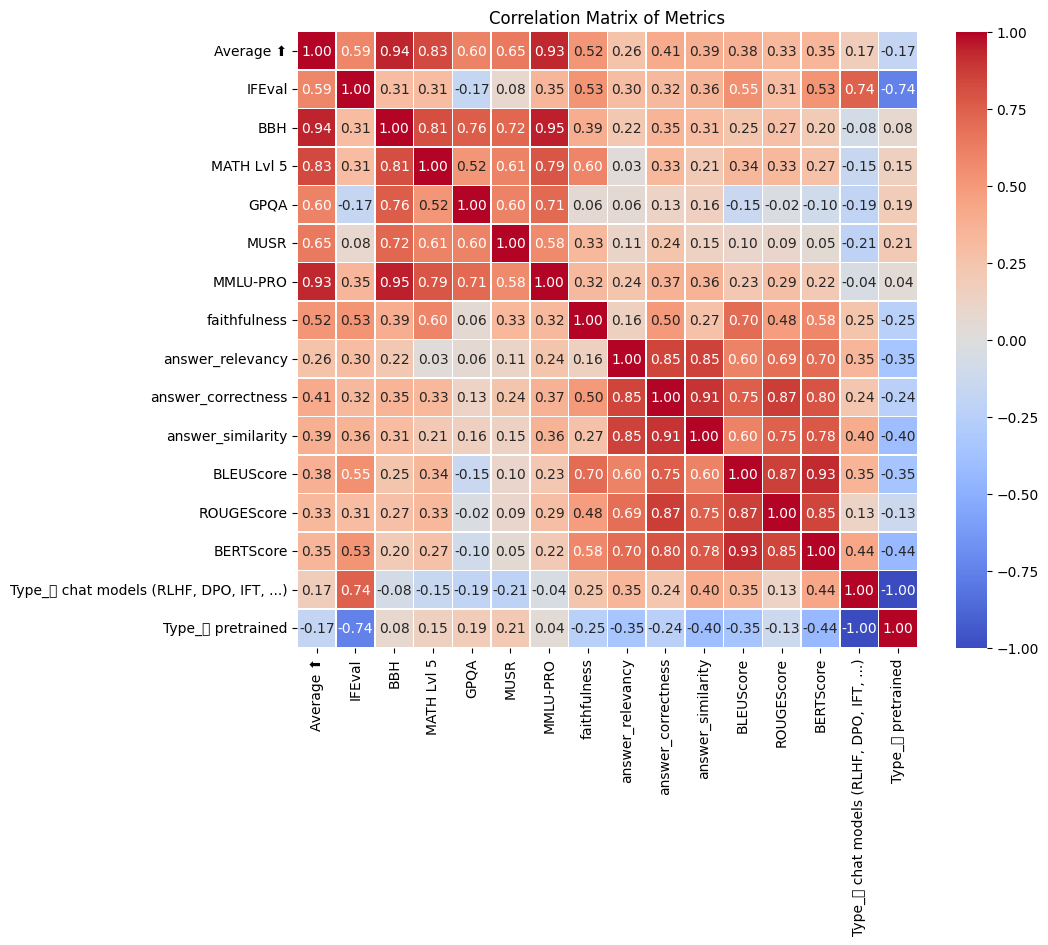

In [42]:
# Plotting the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(df_metrics_combined_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Metrics')
plt.show()

In [47]:
X = df_metrics_combined[['IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO']]
y = df_metrics_combined['faithfulness']

In [48]:
import statsmodels.api as sm
# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           faithfulness   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     3.554
Date:                Thu, 25 Jul 2024   Prob (F-statistic):             0.0237
Time:                        09:47:58   Log-Likelihood:                 19.028
No. Observations:                  21   AIC:                            -24.06
Df Residuals:                      14   BIC:                            -16.74
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4489      0.115      3.919      0.0

In [49]:
for metric in ['faithfulness','answer_relevancy', 'answer_correctness', 'answer_similarity', 'BLEUScore','ROUGEScore', 'BERTScore']:
    y = df_metrics_combined[metric]
    
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X).fit()
    
    # Print the summary of the regression model
    print(metric)
    print(model.summary())

faithfulness
                            OLS Regression Results                            
Dep. Variable:           faithfulness   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     3.554
Date:                Thu, 25 Jul 2024   Prob (F-statistic):             0.0237
Time:                        09:47:58   Log-Likelihood:                 19.028
No. Observations:                  21   AIC:                            -24.06
Df Residuals:                      14   BIC:                            -16.74
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4489      0.115      3

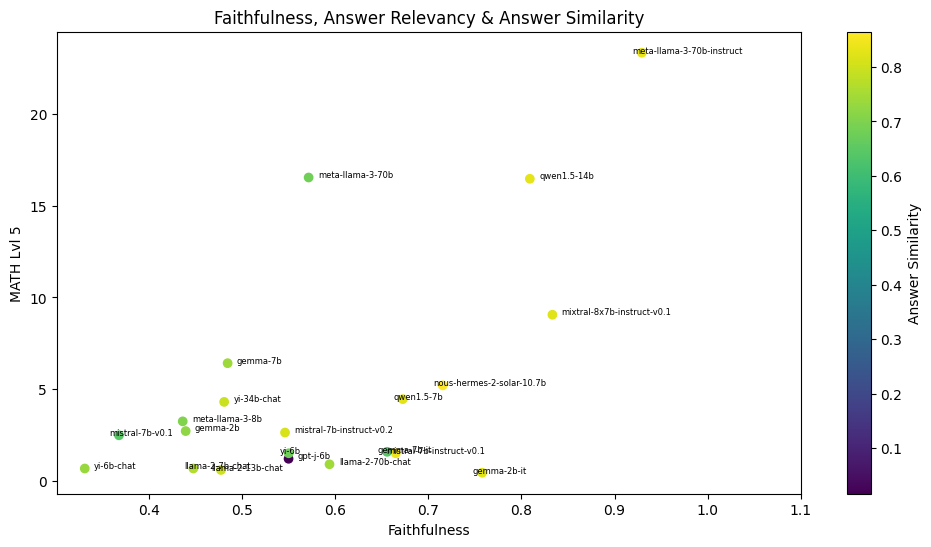

In [70]:
df_metrics_combined["model"] = df_metrics_combined.index
grouped_df = df_metrics_combined.groupby('model')[['faithfulness', 'MATH Lvl 5', 'answer_correctness', 'answer_similarity']].mean()
grouped_df["llm_name"] = grouped_df.index

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter('faithfulness', 'MATH Lvl 5', c='answer_similarity', cmap='viridis', data=grouped_df)

# Adjust text labels with a slight offset based on index
offset = 0.01  # Adjust offset value as needed to prevent overlap
for i, (index, row) in enumerate(grouped_df.iterrows()):
    # Alternate offsets for better visibility
    if i % 2 == 0:
        ax.text(row['faithfulness'] + offset, row['MATH Lvl 5'] + offset, row['llm_name'], fontsize=6)
    else:
        ax.text(row['faithfulness'] - offset, row['MATH Lvl 5'] - offset, row['llm_name'], fontsize=6)

# Set axis labels
ax.set_xlabel('Faithfulness')
ax.set_ylabel('MATH Lvl 5')
ax.set_xlim(right=1.1)  # Extend the x-axis limit for better visibility
ax.set_title('Faithfulness, Answer Relevancy & Answer Similarity')

# Create and label the color bar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Answer Similarity')  # Set color bar label

#plt.savefig("/mnt/data/Faithfulness-vs-Answer-Relevancy-vs-Answer-Similarity.png")
#plt.savefig("/mnt/data/Faithfulness-vs-Answer-Relevancy-vs-Answer-Similarity.pdf")
# Show plot
plt.show()

In [65]:
grouped_df = combined_df.groupby('model').mean()#[['faithfulness', 'MATH Lvl 5', 'answer_correctness', 'answer_similarity']].mean()
grouped_df["llm_name"] = grouped_df.index
grouped_df

TypeError: agg function failed [how->mean,dtype->object]

In [76]:
df_metrics_combined.drop(["model"], axis=1, inplace=True)

In [101]:
df_metrics_combined.columns.values

array(['Average ⬆️', 'IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR',
       'MMLU-PRO', 'Type', 'faithfulness', 'answer_relevancy',
       'answer_correctness', 'answer_similarity', 'BLEUScore',
       'ROUGEScore', 'BERTScore'], dtype=object)

In [102]:
df_metrics_combined.drop(["Average ⬆️"], axis=1, inplace=True)

In [103]:
df_metrics_combined

IFEval    BBH  MATH Lvl 5   GPQA   MUSR  MMLU-PRO  \
Model                                                                           
meta-llama-3-70b-instruct    80.99  50.19       23.34   4.92  10.92     46.74   
meta-llama-3-8b              14.55  24.50        3.25   7.38   6.24     24.55   
mixtral-8x7b-instruct-v0.1   53.95  34.02        9.06   7.61  12.11     29.36   
llama-2-7b-chat              39.65   4.49        0.68   0.56   3.48      7.52   
llama-2-70b-chat             49.58   4.61        0.91   1.90   3.48     15.92   
llama-2-13b-chat             39.85   7.16        0.60   0.00   8.16     10.26   
mistral-7b-instruct-v0.2     54.96  22.91        2.64   3.47   7.61     19.08   
mistral-7b-v0.1              23.86  22.02        2.49   5.59  10.68     22.36   
mistral-7b-instruct-v0.1     45.02  13.79        1.51   0.00   5.77     15.34   
meta-llama-3-70b             16.03  48.71       16.54  19.69  16.01     41.21   
yi-34b-chat                  46.99  37.62        4.31  11.74   8.36     34.37   
yi-6b                        28.93  19.41        1.51   2.57   7.04     22.12   
gemma-2b-it                  26.90   5.21        0.45   3.80   3.03      3.92   
gemma-7b-it                  38.68  11.94        1.59   4.59  12.53      7.72   
nous-hermes-2-solar-10.7b    52.79  34.99        5.21   5.82  13.83     27.31   
gpt-j-6b                     25.22   4.91        1.21   0.00   5.25      2.68   
gemma-7b                     26.59  21.12        6.42   4.92  10.98     21.64   
yi-6b-chat                   33.95  17.00        0.68   5.93   3.57     22.90   
gemma-2b                     20.38   8.25        2.72   0.67   7.56      4.06   
qwen1.5-14b                  29.05  30.06       16.47   5.93  10.46     29.37   
qwen1.5-7b                   26.84  23.08        4.46   6.49   9.16     21.29   

                                                           Type  faithfulness  \
Model                                                                           
meta-llama-3-70b-instruct   💬 chat models (RLHF, DPO, IFT, ...)      0.929193   
meta-llama-3-8b                                    🟢 pretrained      0.436381   
mixtral-8x7b-instruct-v0.1  💬 chat models (RLHF, DPO, IFT, ...)      0.833260   
llama-2-7b-chat             💬 chat models (RLHF, DPO, IFT, ...)      0.447794   
llama-2-70b-chat            💬 chat models (RLHF, DPO, IFT, ...)      0.593958   
llama-2-13b-chat            💬 chat models (RLHF, DPO, IFT, ...)      0.477413   
mistral-7b-instruct-v0.2    💬 chat models (RLHF, DPO, IFT, ...)      0.546210   
mistral-7b-v0.1                                    🟢 pretrained      0.367937   
mistral-7b-instruct-v0.1    💬 chat models (RLHF, DPO, IFT, ...)      0.665079   
meta-llama-3-70b                                   🟢 pretrained      0.571543   
yi-34b-chat                 💬 chat models (RLHF, DPO, IFT, ...)      0.480877   
yi-6b                                              🟢 pretrained      0.550175   
gemma-2b-it                 💬 chat models (RLHF, DPO, IFT, ...)      0.757843   
gemma-7b-it                 💬 chat models (RLHF, DPO, IFT, ...)      0.655810   
nous-hermes-2-solar-10.7b   💬 chat models (RLHF, DPO, IFT, ...)      0.715556   
gpt-j-6b                                           🟢 pretrained      0.550000   
gemma-7b                                           🟢 pretrained      0.484596   
yi-6b-chat                  💬 chat models (RLHF, DPO, IFT, ...)      0.331220   
gemma-2b                                           🟢 pretrained      0.439558   
qwen1.5-14b                                        🟢 pretrained      0.809021   
qwen1.5-7b                                         🟢 pretrained      0.672658   

                            answer_relevancy  answer_correctness  \
Model                                                              
meta-llama-3-70b-instruct           0.640306            0.434311   
meta-llama-3-8b                     0.615669            0.352124   
mixtral-8x7b-instruct-v0.1  

                                               PC0       PC1       PC2  \
IFEval                                   -0.249499 -0.138967  0.459142   
BBH                                      -0.221765  0.391479  0.159178   
MATH Lvl 5                               -0.211501  0.353296  0.131336   
GPQA                                     -0.082018  0.405024  0.070695   
MUSR                                     -0.135225  0.370958  0.068108   
MMLU-PRO                                 -0.223537  0.358516  0.154830   
faithfulness                             -0.261544  0.045912  0.156086   
answer_relevancy                         -0.289596 -0.123947 -0.253600   
answer_correctness                       -0.346042 -0.036896 -0.273644   
answer_similarity                        -0.325107 -0.085621 -0.186061   
BLEUScore                                -0.334091 -0.126824 -0.108404   
ROUGEScore                               -0.322118 -0.063235 -0.332576   
BERTScore                             

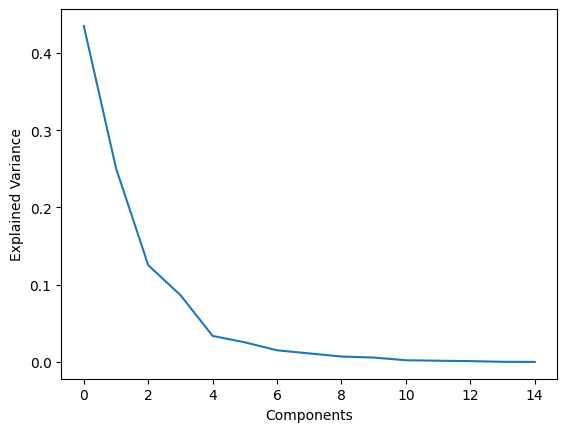

In [104]:
import pandas
from sklearn.decomposition import PCA
import numpy
import matplotlib.pyplot as plot

df = pd.get_dummies(df_metrics_combined)
# You must normalize the data before applying the fit method
df_normalized=(df - df.mean()) / df.std()
pca = PCA(n_components=df.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pandas.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df.columns)
print(loadings)

plot.plot(pca.explained_variance_ratio_)
plot.ylabel('Explained Variance')
plot.xlabel('Components')
plot.show()

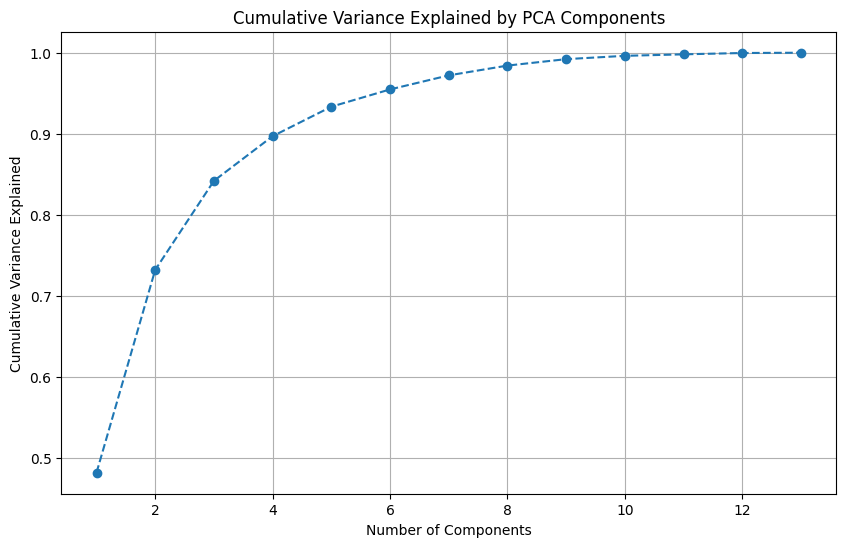

    Explained Variance
0             0.482287
1             0.250066
2             0.109731
3             0.055052
4             0.036336
5             0.021307
6             0.017317
7             0.012054
8             0.007936
9             0.004092
10            0.001836
11            0.001649
12            0.000338


In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume `data` is your dataframe loaded from a CSV or created manually from the provided image
data = df
# Drop any non-numeric columns for PCA
numeric_data = data.select_dtypes(include=[float, int])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply PCA
pca = PCA()
pca.fit(scaled_data)

# Calculate the cumulative variance explained
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative variance explained
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid()
plt.show()

# Show the explained variance by each component
explained_variance = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])

print(explained_variance_df)


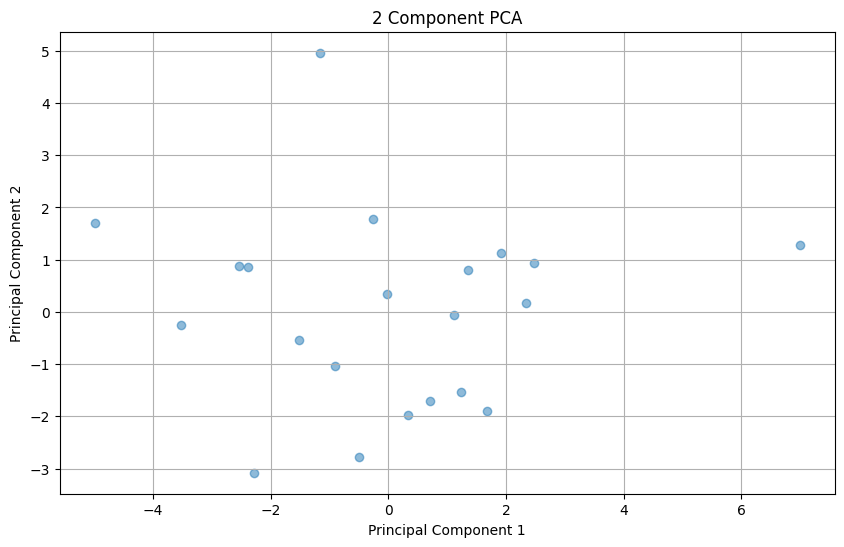

   Explained Variance
0            0.482287
1            0.250066


In [106]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume `data` is your dataframe loaded from a CSV or created manually from the provided image

# Drop any non-numeric columns for PCA
numeric_data = data.select_dtypes(include=[float, int])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply PCA with 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the 2 principal components
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Plot the 2 principal components
plt.figure(figsize=(10, 6))
plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], alpha=0.5)
plt.title('2 Component PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

# Show the explained variance by the 2 components
explained_variance = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])

print(explained_variance_df)


In [107]:
scaled_data

array([[ 2.82491818e+00,  2.11918635e+00,  2.99159995e+00,
        -2.79686503e-03,  7.09580078e-01,  2.23897700e+00,
         2.20660434e+00, -1.97735411e-01,  8.13313527e-01,
         6.03190450e-01,  1.73240991e+00,  1.17839314e+00,
         1.19102515e+00],
       [-1.43135736e+00,  2.38791869e-01, -2.94416617e-01,
         5.52918702e-01, -6.03991783e-01,  3.48250146e-01,
        -9.66431075e-01, -4.04768918e-01, -1.81988454e-02,
        -1.49373302e-01, -8.19254659e-01, -4.52310723e-02,
        -1.07313347e+00],
       [ 1.09268322e+00,  9.35613801e-01,  6.55894796e-01,
         6.04875848e-01,  1.04358660e+00,  7.58092245e-01,
         1.58892952e+00, -3.29318768e-01,  5.01620812e-01,
         5.34275878e-01,  8.53697933e-01,  6.86992012e-01,
         7.57747241e-01],
       [ 1.76597425e-01, -1.22585171e+00, -7.14778119e-01,
        -9.87723642e-01, -1.37866237e+00, -1.10281242e+00,
        -8.92951324e-01, -3.78678050e-01, -2.73729270e-01,
         2.08970202e-01, -3.75625742e

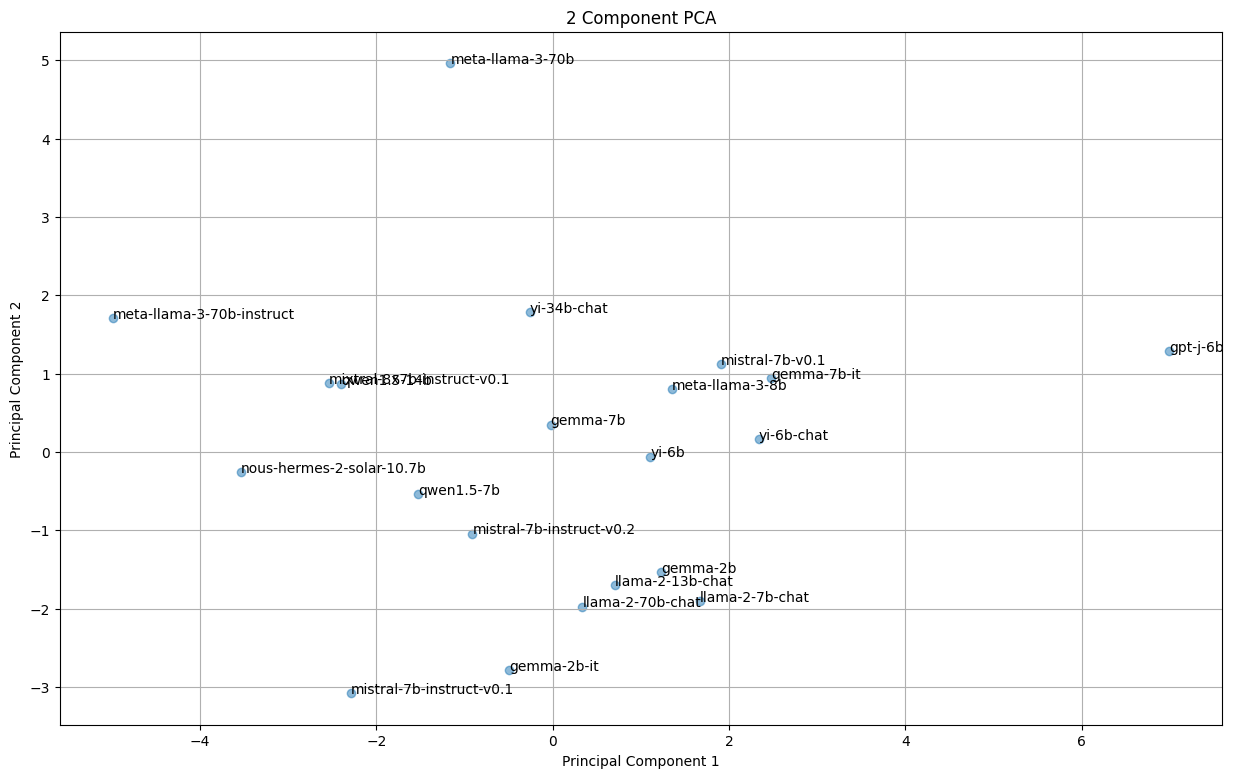

   Explained Variance
0            0.482287
1            0.250066


In [108]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume `data` is your dataframe loaded from a CSV or created manually from the provided image

# Drop any non-numeric columns for PCA
numeric_data = data.select_dtypes(include=[float, int])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply PCA with 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the 2 principal components
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'], index=numeric_data.index)

# Plot the 2 principal components
plt.figure(figsize=(15, 9))
plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], alpha=0.5)

# Annotate each point with its index
for i in principal_df.index:
    plt.annotate(i, (principal_df.loc[i, 'Principal Component 1'], principal_df.loc[i, 'Principal Component 2']))

plt.title('2 Component PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.savefig('foo.png', bbox_inches='tight')
plt.show()

# Show the explained variance by the 2 components
explained_variance = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])

print(explained_variance_df)


In [109]:
plt.savefig('foo.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

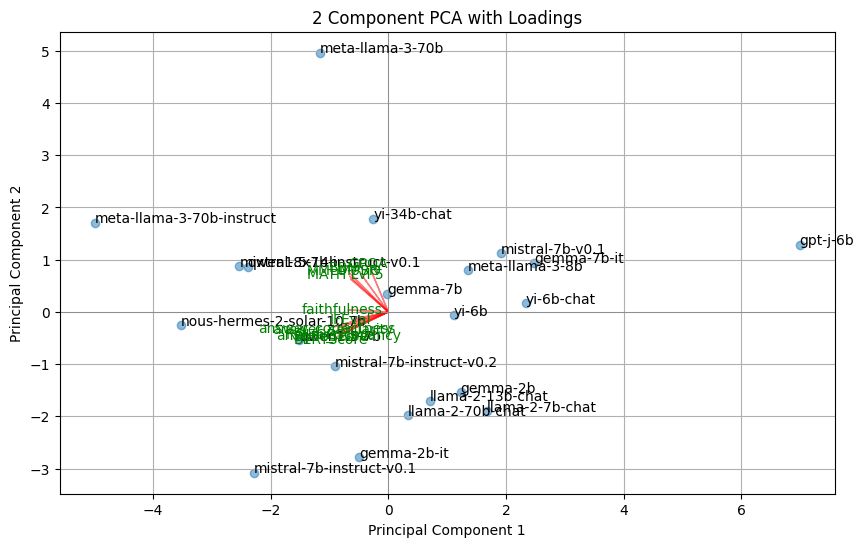

   Explained Variance
0            0.482287
1            0.250066


In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assume `data` is your dataframe loaded from a CSV or created manually from the provided image

# Drop any non-numeric columns for PCA
numeric_data = data.select_dtypes(include=[float, int])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply PCA with 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the 2 principal components
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'], index=numeric_data.index)

# Plot the 2 principal components
plt.figure(figsize=(10, 6))
plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], alpha=0.5)

# Annotate each point with its index
for i in principal_df.index:
    plt.annotate(i, (principal_df.loc[i, 'Principal Component 1'], principal_df.loc[i, 'Principal Component 2']))

# Plot the loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, (x, y) in enumerate(zip(loadings[:, 0], loadings[:, 1])):
    plt.arrow(0, 0, x, y, color='r', alpha=0.5)
    plt.text(x * 1.15, y * 1.15, numeric_data.columns[i], color='g', ha='center', va='center')

plt.title('2 Component PCA with Loadings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.show()

# Show the explained variance by the 2 components
explained_variance = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])

print(explained_variance_df)


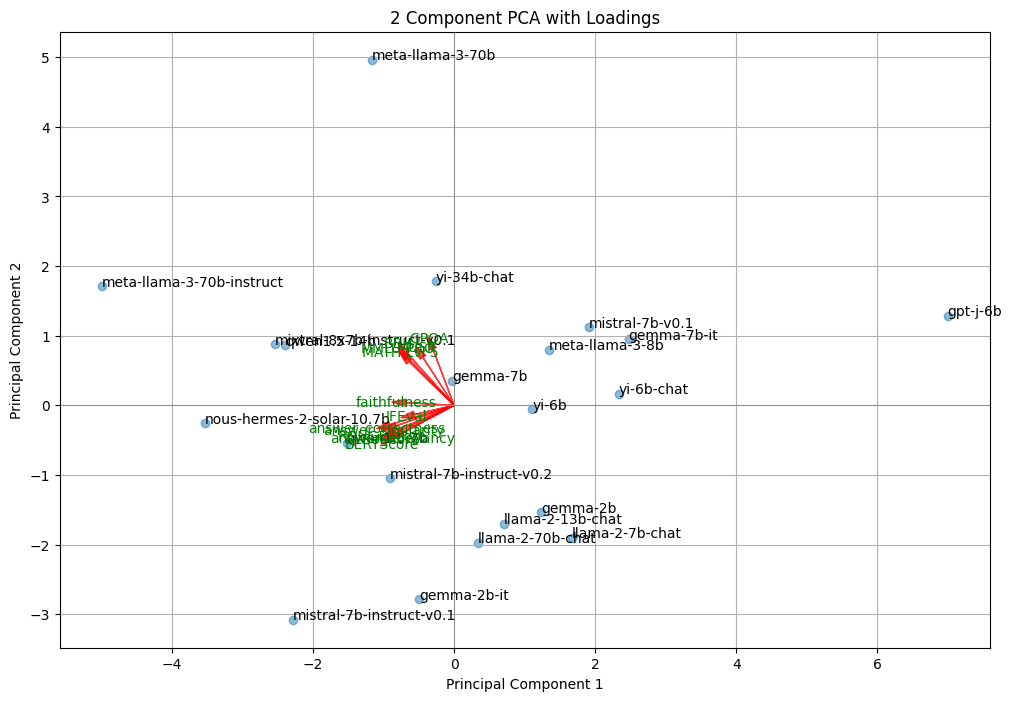

   Explained Variance
0            0.482287
1            0.250066


In [111]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assume `data` is your dataframe loaded from a CSV or created manually from the provided image

# Drop any non-numeric columns for PCA
numeric_data = data.select_dtypes(include=[float, int])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply PCA with 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the 2 principal components
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'], index=numeric_data.index)

# Plot the 2 principal components
plt.figure(figsize=(12, 8))
plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], alpha=0.5)

# Annotate each point with its index
for i in principal_df.index:
    plt.annotate(i, (principal_df.loc[i, 'Principal Component 1'], principal_df.loc[i, 'Principal Component 2']))

# Plot the loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, (x, y) in enumerate(zip(loadings[:, 0], loadings[:, 1])):
    plt.arrow(0, 0, x, y, color='r', alpha=0.75, head_width=0.1, head_length=0.2)
    plt.text(x * 1.2, y * 1.2, numeric_data.columns[i], color='g', ha='center', va='center')

plt.title('2 Component PCA with Loadings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.show()

# Show the explained variance by the 2 components
explained_variance = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])

print(explained_variance_df)


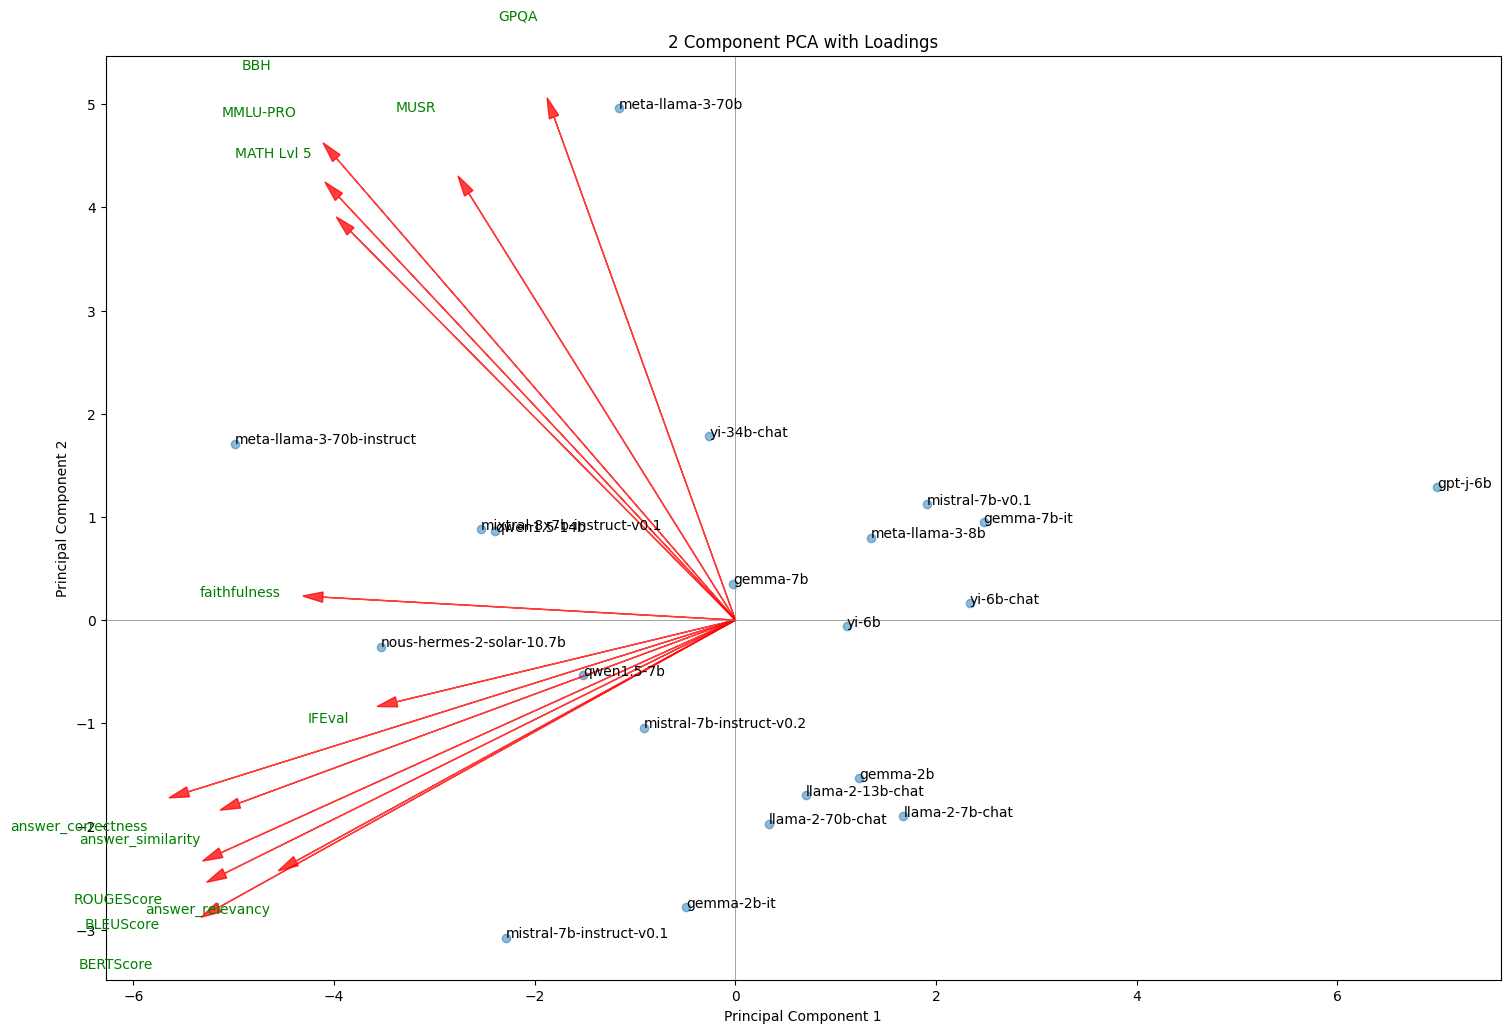

   Explained Variance
0            0.482287
1            0.250066


In [114]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assume `data` is your dataframe loaded from a CSV or created manually from the provided image

# Drop any non-numeric columns for PCA
numeric_data = data.select_dtypes(include=[float, int])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply PCA with 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the 2 principal components
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'], index=numeric_data.index)

# Plot the 2 principal components
plt.figure(figsize=(18, 12))
plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], alpha=0.5)

# Annotate each point with its index
for i in principal_df.index:
    plt.annotate(i, (principal_df.loc[i, 'Principal Component 1'], principal_df.loc[i, 'Principal Component 2']))

# Plot the loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
scaling_factor = 6  # Increase this factor to make the lines longer
for i, (x, y) in enumerate(zip(loadings[:, 0], loadings[:, 1])):
    plt.arrow(0, 0, x * scaling_factor, y * scaling_factor, color='r', alpha=0.75, head_width=0.1, head_length=0.2)
    plt.text(x * scaling_factor * 1.2, y * scaling_factor * 1.2, numeric_data.columns[i], color='g', ha='center', va='center')

plt.title('2 Component PCA with Loadings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.show()

# Show the explained variance by the 2 components
explained_variance = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])

print(explained_variance_df)


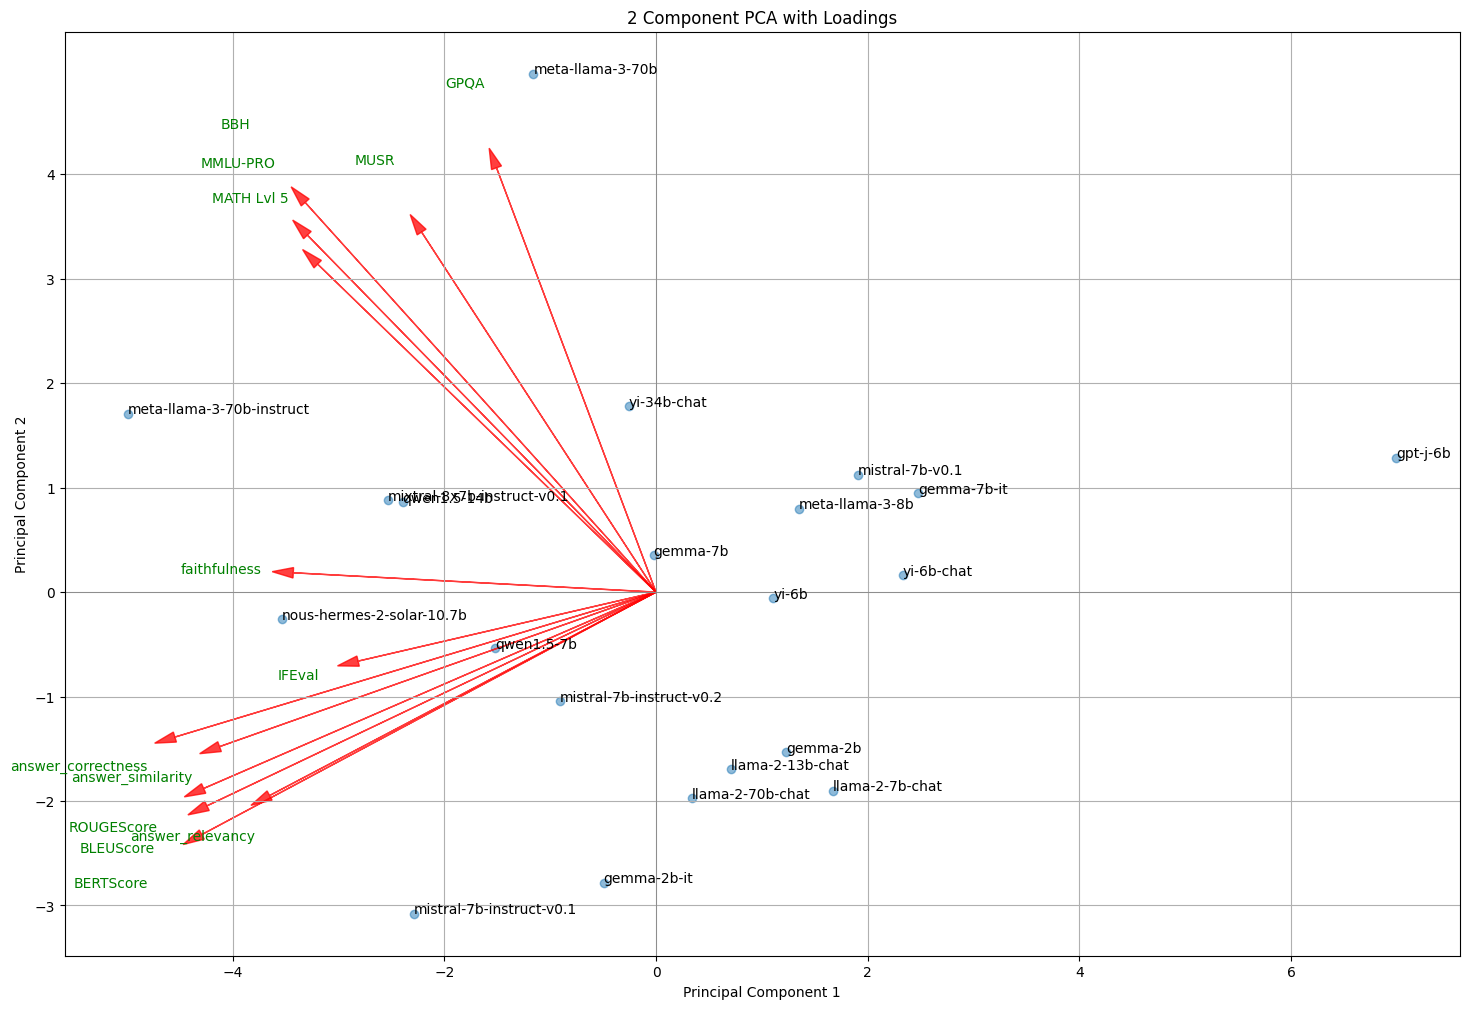

   Explained Variance
0            0.482287
1            0.250066


In [140]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assume `data` is your dataframe loaded from a CSV or created manually from the provided image

# Drop any non-numeric columns for PCA
numeric_data = data.select_dtypes(include=[float, int])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply PCA with 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the 2 principal components
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'], index=numeric_data.index)

# Plot the 2 principal components
plt.figure(figsize=(18, 12))
plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], alpha=0.5)

# Annotate each point with its index
for i in principal_df.index:
    plt.annotate(i, (principal_df.loc[i, 'Principal Component 1'], principal_df.loc[i, 'Principal Component 2']))

# Plot the loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
scaling_factor = 5  # Increase this factor to make the lines longer
for i, (x, y) in enumerate(zip(loadings[:, 0], loadings[:, 1])):
    plt.arrow(0, 0, x * scaling_factor, y * scaling_factor, color='r', alpha=0.75, head_width=0.1, head_length=0.2)
    plt.text(x * scaling_factor * 1.2, y * scaling_factor * 1.2, numeric_data.columns[i], color='g', ha='center', va='center')

plt.title('2 Component PCA with Loadings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Set custom ticks on the Y-axis
y_ticks = np.arange(-3, 4.5, 1)  # Example: from -10 to 10 with step 2
plt.yticks(y_ticks)

plt.grid()
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.show()

# Show the explained variance by the 2 components
explained_variance = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])

print(explained_variance_df)


In [125]:
df_metrics_combined

IFEval    BBH  MATH Lvl 5   GPQA   MUSR  MMLU-PRO  \
Model                                                                           
meta-llama-3-70b-instruct    80.99  50.19       23.34   4.92  10.92     46.74   
meta-llama-3-8b              14.55  24.50        3.25   7.38   6.24     24.55   
mixtral-8x7b-instruct-v0.1   53.95  34.02        9.06   7.61  12.11     29.36   
llama-2-7b-chat              39.65   4.49        0.68   0.56   3.48      7.52   
llama-2-70b-chat             49.58   4.61        0.91   1.90   3.48     15.92   
llama-2-13b-chat             39.85   7.16        0.60   0.00   8.16     10.26   
mistral-7b-instruct-v0.2     54.96  22.91        2.64   3.47   7.61     19.08   
mistral-7b-v0.1              23.86  22.02        2.49   5.59  10.68     22.36   
mistral-7b-instruct-v0.1     45.02  13.79        1.51   0.00   5.77     15.34   
meta-llama-3-70b             16.03  48.71       16.54  19.69  16.01     41.21   
yi-34b-chat                  46.99  37.62        4.31  11.74   8.36     34.37   
yi-6b                        28.93  19.41        1.51   2.57   7.04     22.12   
gemma-2b-it                  26.90   5.21        0.45   3.80   3.03      3.92   
gemma-7b-it                  38.68  11.94        1.59   4.59  12.53      7.72   
nous-hermes-2-solar-10.7b    52.79  34.99        5.21   5.82  13.83     27.31   
gpt-j-6b                     25.22   4.91        1.21   0.00   5.25      2.68   
gemma-7b                     26.59  21.12        6.42   4.92  10.98     21.64   
yi-6b-chat                   33.95  17.00        0.68   5.93   3.57     22.90   
gemma-2b                     20.38   8.25        2.72   0.67   7.56      4.06   
qwen1.5-14b                  29.05  30.06       16.47   5.93  10.46     29.37   
qwen1.5-7b                   26.84  23.08        4.46   6.49   9.16     21.29   

                                                           Type  faithfulness  \
Model                                                                           
meta-llama-3-70b-instruct   💬 chat models (RLHF, DPO, IFT, ...)      0.929193   
meta-llama-3-8b                                    🟢 pretrained      0.436381   
mixtral-8x7b-instruct-v0.1  💬 chat models (RLHF, DPO, IFT, ...)      0.833260   
llama-2-7b-chat             💬 chat models (RLHF, DPO, IFT, ...)      0.447794   
llama-2-70b-chat            💬 chat models (RLHF, DPO, IFT, ...)      0.593958   
llama-2-13b-chat            💬 chat models (RLHF, DPO, IFT, ...)      0.477413   
mistral-7b-instruct-v0.2    💬 chat models (RLHF, DPO, IFT, ...)      0.546210   
mistral-7b-v0.1                                    🟢 pretrained      0.367937   
mistral-7b-instruct-v0.1    💬 chat models (RLHF, DPO, IFT, ...)      0.665079   
meta-llama-3-70b                                   🟢 pretrained      0.571543   
yi-34b-chat                 💬 chat models (RLHF, DPO, IFT, ...)      0.480877   
yi-6b                                              🟢 pretrained      0.550175   
gemma-2b-it                 💬 chat models (RLHF, DPO, IFT, ...)      0.757843   
gemma-7b-it                 💬 chat models (RLHF, DPO, IFT, ...)      0.655810   
nous-hermes-2-solar-10.7b   💬 chat models (RLHF, DPO, IFT, ...)      0.715556   
gpt-j-6b                                           🟢 pretrained      0.550000   
gemma-7b                                           🟢 pretrained      0.484596   
yi-6b-chat                  💬 chat models (RLHF, DPO, IFT, ...)      0.331220   
gemma-2b                                           🟢 pretrained      0.439558   
qwen1.5-14b                                        🟢 pretrained      0.809021   
qwen1.5-7b                                         🟢 pretrained      0.672658   

                            answer_relevancy  answer_correctness  \
Model                                                              
meta-llama-3-70b-instruct           0.640306            0.434311   
meta-llama-3-8b                     0.615669            0.352124   
mixtral-8x7b-instruct-v0.1  

/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128994 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128172 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128994 missing from current font.
  font.set_text(s, 0, flags=flags)


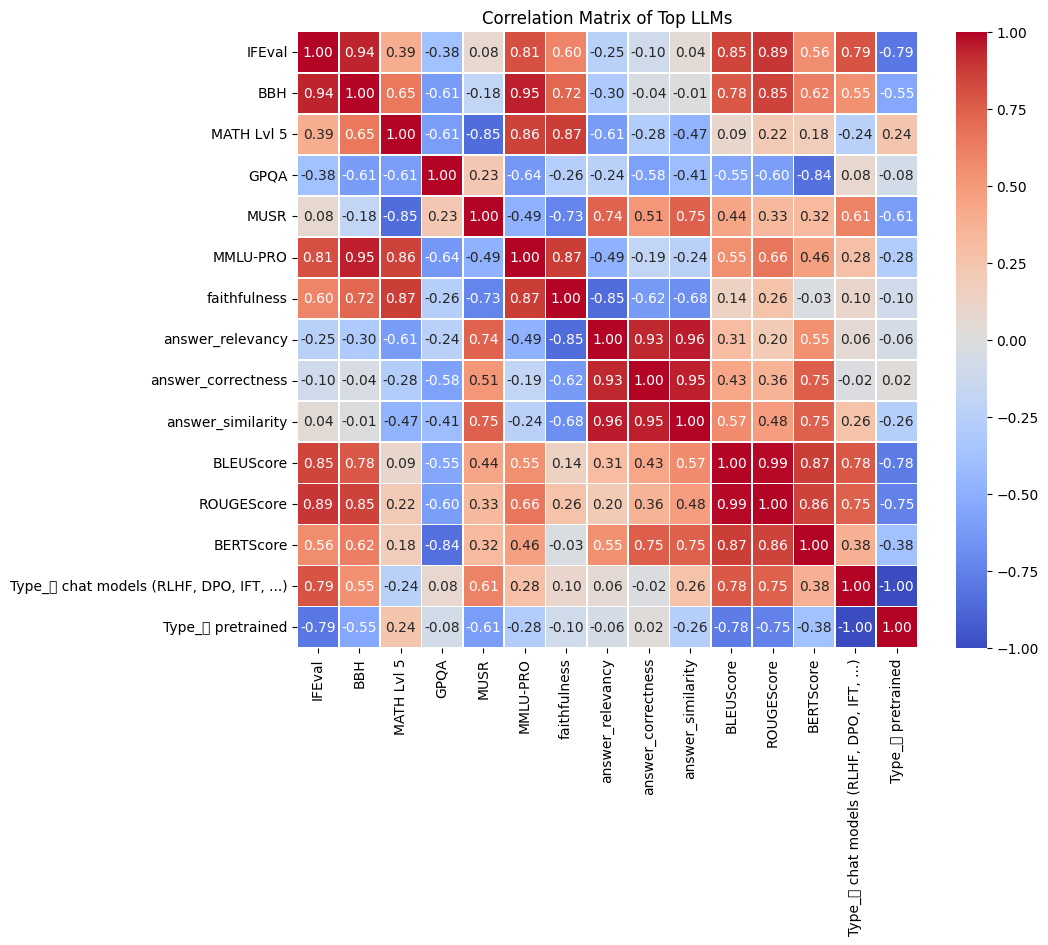

In [137]:
#df_metrics_combined[df_metrics_combined['Model'] == 'llama-2-70b-chat']
top_portfolio = df_metrics_combined.loc[['meta-llama-3-70b-instruct','mixtral-8x7b-instruct-v0.1','nous-hermes-2-solar-10.7b','qwen1.5-14b']]#.corr()
top_portfolio_corr = pd.get_dummies(top_portfolio).corr()

# Plotting the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(top_portfolio_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Top LLMs')
plt.show()

/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128994 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128172 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128994 missing from current font.
  font.set_text(s, 0, flags=flags)


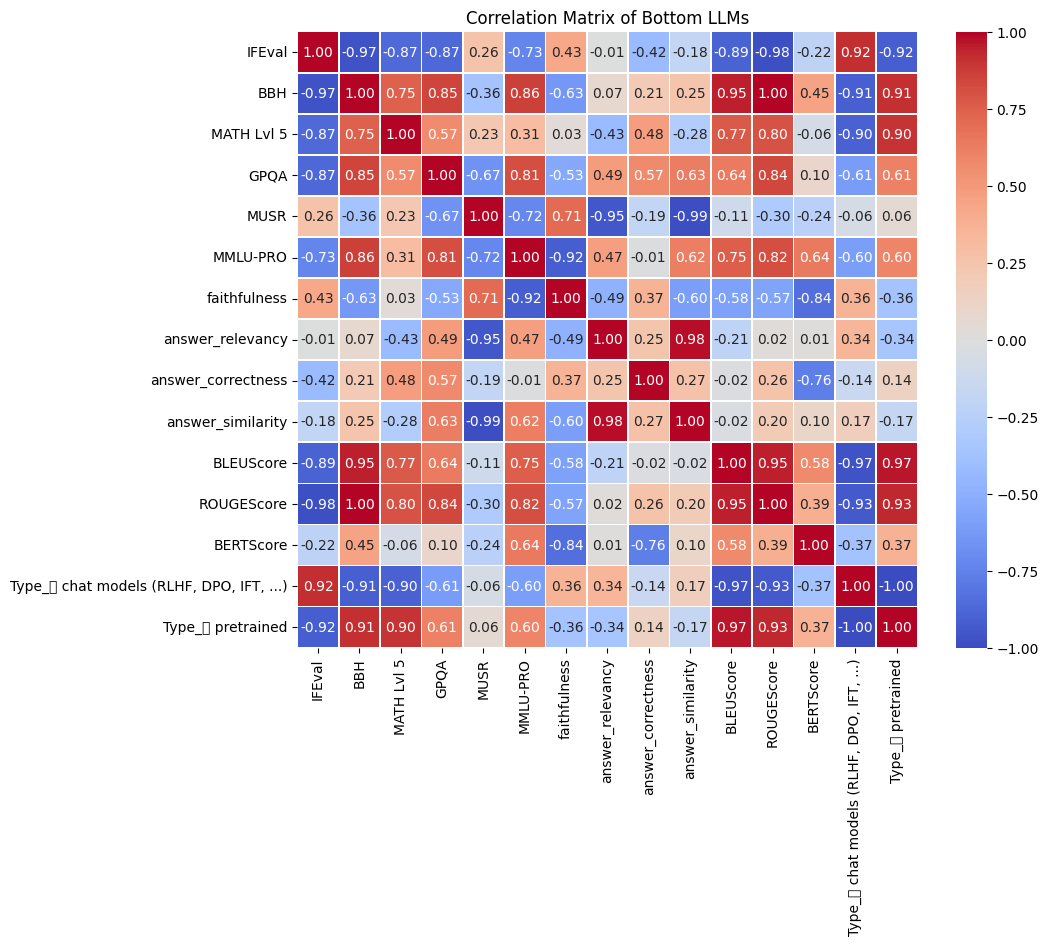

In [138]:
#df_metrics_combined[df_metrics_combined['Model'] == 'llama-2-70b-chat']
bottom_portfolio = df_metrics_combined.loc[['gemma-7b-it','mistral-7b-v0.1','meta-llama-3-8b','yi-6b-chat']]#.corr()
bottom_portfolio_corr = pd.get_dummies(bottom_portfolio).corr()

# Plotting the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(bottom_portfolio_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Bottom LLMs')
plt.show()

### Analysis 2

In [206]:
df_llm_metrics2 = pd.read_csv('/home/hamzicd/DS/Paper1-RAGG/impl/LLMs-Overview2-Paper-Sheet4.csv')
df_llm_metrics2

Raw model  \
0   0: {model: 'meta-llama-3-70b-instruct', runs: ...   
1       1: {model: 'meta-llama-3-8b', runs: 48900000}   
2   2: {model: 'meta-llama-3-8b-instruct', runs: 3...   
3   3: {model: 'mixtral-8x7b-instruct-v0.1', runs:...   
4        4: {model: 'llama-2-7b-chat', runs: 8400000}   
5       5: {model: 'llama-2-70b-chat', runs: 7400000}   
6       6: {model: 'llama-2-13b-chat', runs: 4400000}   
7   7: {model: 'mistral-7b-instruct-v0.2', runs: 2...   
8        8: {model: 'mistral-7b-v0.1', runs: 1700000}   
9   9: {model: 'mistral-7b-instruct-v0.1', runs: 9...   
10          10: {model: 'dolly-v2-12b', runs: 453100}   
11      11: {model: 'meta-llama-3-70b', runs: 339400}   
12           12: {model: 'yi-34b-chat', runs: 253900}   
13            13: {model: 'vicuna-13b', runs: 251200}   
14                 14: {model: 'yi-6b', runs: 158100}   
15            15: {model: 'flan-t5-xl', runs: 136600}   
16  16: {model: 'stablelm-tuned-alpha-7b', runs: 1...   
17               17: {model: 'llama-7b', runs: 98500}   
18            18: {model: 'gemma-2b-it', runs: 82300}   
19  19: {model: 'gemma-7b-it', runs: 64900.0000000...   
20  20: {model: 'nous-hermes-2-solar-10.7b', runs:...   
21  21: {model: 'oasst-sft-1-pythia-12b', runs: 32...   
22  22: {model: 'nous-hermes-2-yi-34b-gguf', runs:...   
23                23: {model: 'gpt-j-6b', runs: 8400}   
24  24: {model: 'nous-hermes-llama2-awq', runs: 7200}   
25                25: {model: 'gemma-7b', runs: 6800}   
26              26: {model: 'yi-6b-chat', runs: 4000}   
27             27: {model: 'qwen1.5-72b', runs: 3800}   
28                   28: {model: 'phi-2', runs: 2700}   
29       29: {model: 'replit-code-v1-3b', runs: 1900}   
30                 30: {model: 'gemma-2b', runs: 588}   
31              31: {model: 'qwen1.5-14b', runs: 281}   
32               32: {model: 'mamba-2.8b', runs: 216}   
33          33: {model: 'phixtral-2x2_​8', runs: 197}   
34               34: {model: 'qwen1.5-7b', runs: 109}   
35               35: {model: 'mamba-130m', runs: 101}   
36                   36: {model: 'olmo-7b', runs: 74}   
37                37: {model: 'mamba-1.4b', runs: 45}   
38         38: {model: 'mamba-2.8b-slimpj', runs: 45}   
39                39: {model: 'mamba-370m', runs: 33}   
40                40: {model: 'mamba-790m', runs: 27}   

                         Model         Company  # Parameter  Context Size  \
0    meta-llama-3-70b-instruct        Facebook         70.0           8.0   
1              meta-llama-3-8b        Facebook          8.0           8.0   
2     meta-llama-3-8b-instruct        Facebook          8.0           8.0   
3   mixtral-8x7b-instruct-v0.1      Mistral AI         56.0          32.0   
4              llama-2-7b-chat        Facebook          7.0           4.0   
5             llama-2-70b-chat        Facebook         70.0           4.0   
6             llama-2-13b-chat        Facebook         13.0           4.0   
7     mistral-7b-instruct-v0.2      Mistral AI          7.0           8.0   
8              mistral-7b-v0.1      Mistral AI          7.0           8.0   
9     mistral-7b-instruct-v0.1      Mistral AI          7.0           8.0   
10                dolly-v2-12b      Databricks         12.0           2.0   
11            meta-llama-3-70b        Facebook         70.0           8.0   
12                 yi-34b-chat           01.AI         34.0           4.0   
13                  vicuna-13b       lmsys.org         13.0           2.0   
14                       yi-6b           01.AI          6.0           4.0   
15                  flan-t5-xl             NaN          NaN           NaN   
16     stablelm-tuned-alpha-7b             NaN          NaN           NaN   
17                    llama-7b             NaN          NaN           NaN   
18                 gemma-2b-it          Google          2.0           8.0   
19                 gemma-7b-it          Google          7.0           8.0   
20   nous-hermes-2-solar-10.7b  

In [207]:
df_llm_metrics2.columns

Index(['Raw model', 'Model', 'Company', '# Parameter', 'Context Size',
       'Average ⬆️', 'IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO',
       'Type'],
      dtype='object')

In [208]:
df_llm_metrics2.dropna(inplace=True)
df_llm_metrics2.index = df_llm_metrics2.Model

In [209]:
df_llm_metrics2.drop(columns=['Average ⬆️', 'Raw model','Model'], inplace=True)

In [210]:
df_llm_metrics2.head()

Company  # Parameter  Context Size  IFEval  \
Model                                                                       
meta-llama-3-70b-instruct     Facebook         70.0           8.0   80.99   
meta-llama-3-8b               Facebook          8.0           8.0   14.55   
meta-llama-3-8b-instruct      Facebook          8.0           8.0   74.08   
mixtral-8x7b-instruct-v0.1  Mistral AI         56.0          32.0   53.95   
llama-2-7b-chat               Facebook          7.0           4.0   39.65   

                              BBH  MATH Lvl 5  GPQA   MUSR  MMLU-PRO  \
Model                                                                  
meta-llama-3-70b-instruct   50.19       23.34  4.92  10.92     46.74   
meta-llama-3-8b             24.50        3.25  7.38   6.24     24.55   
meta-llama-3-8b-instruct    28.24        8.69  1.23   1.60     29.60   
mixtral-8x7b-instruct-v0.1  34.02        9.06  7.61  12.11     29.36   
llama-2-7b-chat              4.49        0.68  0.56   3.48      7.52   

                                                           Type  
Model                                                            
meta-llama-3-70b-instruct   💬 chat models (RLHF, DPO, IFT, ...)  
meta-llama-3-8b                                    🟢 pretrained  
meta-llama-3-8b-instruct    💬 chat models (RLHF, DPO, IFT, ...)  
mixtral-8x7b-instruct-v0.1  💬 chat models (RLHF, DPO, IFT, ...)  
llama-2-7b-chat             💬 chat models (RLHF, DPO, IFT, ...)

In [211]:
#%pip install --user prince

In [212]:
import prince

In [213]:
dataset = df_llm_metrics2

mca = prince.MCA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(dataset)

In [214]:
mca.column_coordinates(dataset)#.plot()#.head()

0         1
Company_01.AI                                 -0.193088  0.112730
Company_Alibaba Cloud                         -0.314201  0.644103
Company_Databricks                             2.779151 -0.826735
Company_EleutherAI                             0.859503  0.425427
Company_Facebook                              -0.400963 -0.169751
...                                                 ...       ...
MMLU-PRO_41.21                                -0.321312  0.074438
MMLU-PRO_46.74                                -0.397469 -0.012192
Type_💬 chat models (RLHF, DPO, IFT, ...)      -0.389318 -0.341347
Type_🔶 fine-tuned on domain-specific datasets  3.016823 -1.175096
Type_🟢 pretrained                             -0.097251  0.678771

[170 rows x 2 columns]

In [216]:
mca.plot(
    dataset,
    x_component=0,
    y_component=1,
    show_column_markers=False,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=True
)

alt.LayerChart(...)

In [217]:
mca.row_cosine_similarities(dataset)#.head()

0             1
Model                                             
meta-llama-3-70b-instruct   0.010279  8.522993e-06
meta-llama-3-8b             0.013681  4.577796e-03
meta-llama-3-8b-instruct    0.026287  2.678080e-03
mixtral-8x7b-instruct-v0.1  0.008891  6.356577e-03
llama-2-7b-chat             0.015556  9.138901e-03
llama-2-70b-chat            0.008104  1.000325e-02
llama-2-13b-chat            0.000805  1.462470e-02
mistral-7b-instruct-v0.2    0.006945  1.722621e-02
mistral-7b-v0.1             0.019441  9.255973e-03
mistral-7b-instruct-v0.1    0.001797  1.305007e-02
dolly-v2-12b                0.437352  3.410537e-02
meta-llama-3-70b            0.006157  2.911733e-04
yi-34b-chat                 0.001814  4.577591e-04
yi-6b                       0.001402  3.051590e-03
gemma-2b-it                 0.022431  2.432986e-03
gemma-7b-it                 0.022720  2.212200e-04
nous-hermes-2-solar-10.7b   0.011329  7.239471e-02
oasst-sft-1-pythia-12b      0.538556  1.039937e-01
gpt-j-6b                    0.042258  9.123230e-03
gemma-7b                    0.026478  3.067705e-03
yi-6b-chat                  0.004015  3.758726e-07
phi-2                       0.096989  7.019053e-01
gemma-2b                    0.013244  1.441779e-02
qwen1.5-14b                 0.005178  4.938806e-02
qwen1.5-7b                  0.005598  3.365438e-03

In [218]:
famd = prince.FAMD(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)
famd = famd.fit(dataset)

/home/hamzicd/.local/lib/python3.10/site-packages/prince/pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.34641016151377546, -0.282842712474619, -0.19999999999999998, -0.5291502622129182, -0.39999999999999997, -0.7211102550927978, -0.6324555320336759]'. Picking the first and converting the rest.
  X = self.scaler_.transform(X.to_numpy())


In [219]:
famd.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              4.975        26.19%                     26.19%
1              2.448        12.88%                     39.07%

In [220]:
famd.row_coordinates(dataset).head()

/home/hamzicd/.local/lib/python3.10/site-packages/prince/pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.34641016151377546, -0.282842712474619, -0.19999999999999998, -0.5291502622129182, -0.39999999999999997, -0.7211102550927978, -0.6324555320336759]'. Picking the first and converting the rest.
  X = self.scaler_.transform(X.to_numpy())


component                          0         1
Model                                         
meta-llama-3-70b-instruct   4.763942 -2.485956
meta-llama-3-8b             0.192966  0.780547
meta-llama-3-8b-instruct    0.686652 -2.488039
mixtral-8x7b-instruct-v0.1  3.015338 -0.345306
llama-2-7b-chat            -1.746040 -1.539131

In [221]:
famd.column_coordinates_

component            0         1
variable                        
# Parameter   0.406962  0.104228
Context Size  0.210719  0.209312
IFEval        0.193650  0.533914
BBH           0.865302  0.000954
MATH Lvl 5    0.671328  0.002416
GPQA          0.542009  0.056203
MUSR          0.416504  0.161553
MMLU-PRO      0.895674  0.010296
Company       0.505818  0.645816
Type          0.267295  0.723199

In [222]:
famd.plot(
    dataset,
    x_component=0,
    y_component=1
)

/home/hamzicd/.local/lib/python3.10/site-packages/prince/pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.34641016151377546, -0.282842712474619, -0.19999999999999998, -0.5291502622129182, -0.39999999999999997, -0.7211102550927978, -0.6324555320336759]'. Picking the first and converting the rest.
  X = self.scaler_.transform(X.to_numpy())


alt.LayerChart(...)

In [226]:
pd.get_dummies(dataset).corr()#.plot()

# Parameter  Context Size  \
# Parameter                                       1.000000      0.143631   
Context Size                                      0.143631      1.000000   
IFEval                                            0.370907      0.057607   
BBH                                               0.511703      0.307770   
MATH Lvl 5                                        0.609004      0.414053   
GPQA                                              0.502491      0.269050   
MUSR                                              0.288097      0.283843   
MMLU-PRO                                          0.578452      0.310225   
Company_01.AI                                    -0.045507     -0.199778   
Company_Alibaba Cloud                            -0.100850      0.771075   
Company_Databricks                               -0.055951     -0.156445   
Company_EleutherAI                               -0.111386     -0.156445   
Company_Facebook                                  0.482288     -0.176720   
Company_Google                                   -0.267783     -0.039352   
Company_Microsoft                                -0.141874     -0.156445   
Company_Mistral AI                                0.023586      0.255789   
Company_NousResearch                             -0.067962     -0.110432   
Company_Open Assistant                           -0.055951     -0.156445   
Type_💬 chat models (RLHF, DPO, IFT, ...)          0.228200     -0.093849   
Type_🔶 fine-tuned on domain-specific datasets    -0.080829     -0.226005   
Type_🟢 pretrained                                -0.187959      0.220863   

                                                 IFEval       BBH  MATH Lvl 5  \
# Parameter                                    0.370907  0.511703    0.609004   
Context Size                                   0.057607  0.307770    0.414053   
IFEval                                         1.000000  0.380335    0.370238   
BBH                                            0.380335  1.000000    0.800275   
MATH Lvl 5                                     0.370238  0.800275    1.000000   
GPQA                                          -0.107888  0.733900    0.507347   
MUSR                                          -0.020282  0.654394    0.477923   
MMLU-PRO                                       0.465912  0.942975    0.778053   
Company_01.AI                                  0.004493  0.114007   -0.168906   
Company_Alibaba Cloud                         -0.144593  0.132681    0.289905   
Company_Databricks                            -0.152036 -0.215531   -0.119115   
Company_EleutherAI                            -0.132298 -0.237911   -0.127265   
Company_Facebook                               0.308669  0.160392    0.315461   
Company_Google                                -0.209136 -0.289934   -0.152023   
Company_Microsoft                             -0.106649  0.114224   -0.084390   
Company_Mistral AI                             0.203036  0.086187   -0.066412   
Company_NousResearch                           0.193565  0.220031    0.014471   
Company_Open Assistant                        -0.305689 -0.239890   -0.119115   
Type_💬 chat models (RLHF, DPO, IFT, ...)       0.760386  0.030970   -0.038232   
Type_🔶 fine-tuned on domain-specific datasets -0.330622 -0.328957   -0.172077   
Type_🟢 pretrained                             -0.592354  0.150585    0.134281   

                                                   GPQA      MUSR  MMLU-PRO  \
# Parameter                                    0.502491  0.288097  0.578452   
Context Size                                   0.269050  0.283843  0.310225   
IFEval                                        -0.107888 -0.020282  0.465912   
BBH                                            0.733900  0.654394  0.942975   
MATH Lvl 5                                     0.507347  0.477923  0.778053   
GPQA                                           1.000000  0.586344  0.692663   
MUSR                                  

/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128310 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128994 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128172 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128310 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:201:

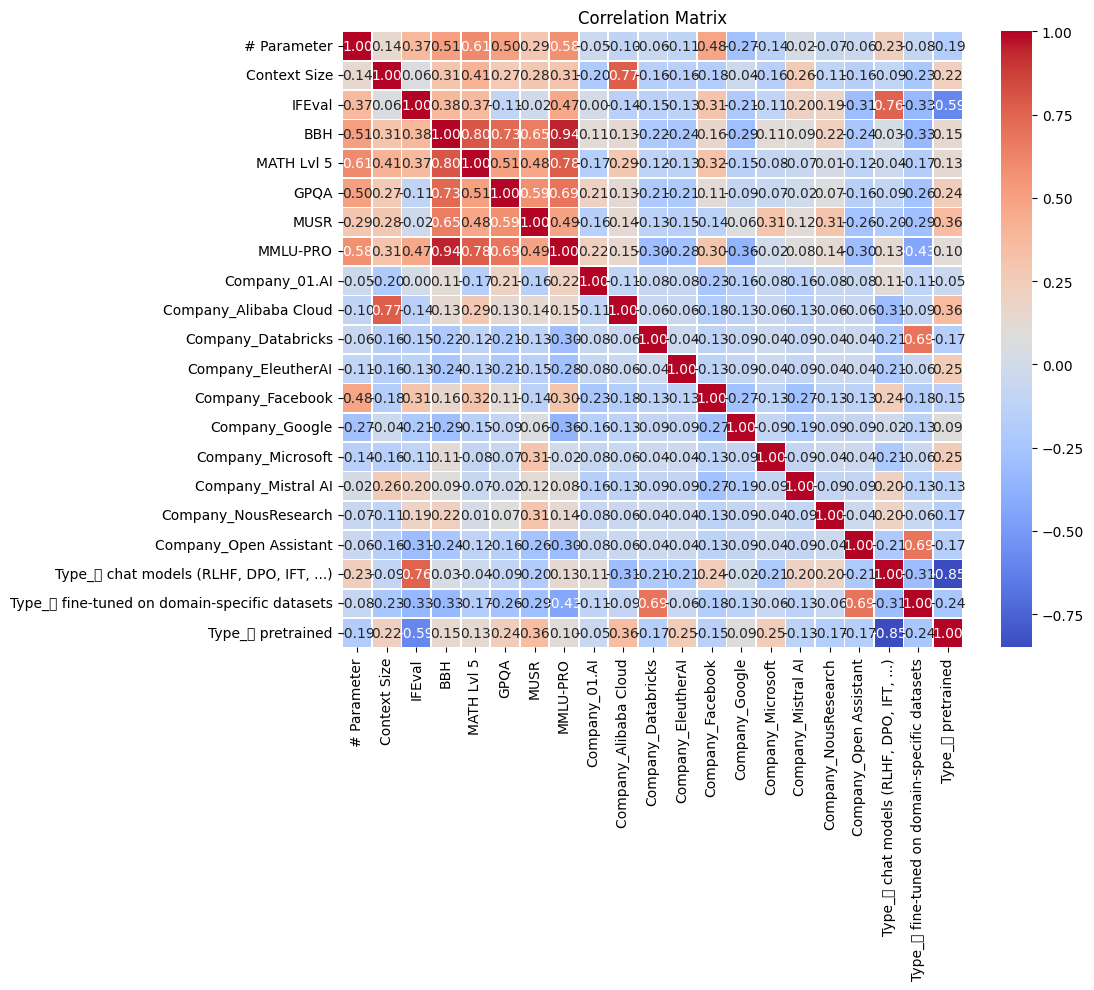

In [244]:
llm_values_corr = pd.get_dummies(dataset).corr()

# Plotting the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(llm_values_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [245]:
#df_metrics_combined = pd.merge(df_llm_metrics, df_metrics1, on='Model')
df_metrics1

faithfulness  answer_relevancy  \
Model                                                        
yi-34b-chat                     0.480877          0.719322   
yi-6b                           0.550175          0.680038   
yi-6b-chat                      0.331220          0.663054   
gemma-2b                        0.439558          0.688003   
gemma-2b-it                     0.757843          0.655167   
gemma-7b                        0.484596          0.629920   
gemma-7b-it                     0.655810          0.564297   
qwen1.5-14b                     0.809021          0.691472   
qwen1.5-7b                      0.672658          0.760178   
llama-2-13b-chat                0.477413          0.746465   
llama-2-70b-chat                0.593958          0.651912   
llama-2-7b-chat                 0.447794          0.618774   
meta-llama-3-70b                0.571543          0.652246   
meta-llama-3-70b-instruct       0.929193          0.640306   
meta-llama-3-8b                 0.436381          0.615669   
mistral-7b-instruct-v0.1        0.665079          0.875687   
mistral-7b-instruct-v0.2        0.546210          0.793255   
mistral-7b-v0.1                 0.367937          0.550233   
mixtral-8x7b-instruct-v0.1      0.833260          0.624648   
nous-hermes-2-solar-10.7b       0.715556          0.845074   
gpt-j-6b                        0.550000          0.274824   

                            answer_correctness  answer_similarity  BLEUScore  \
Model                                                                          
yi-34b-chat                           0.323959           0.797396   0.042056   
yi-6b                                 0.378909           0.678273   0.033960   
yi-6b-chat                            0.266233           0.735213   0.013687   
gemma-2b                              0.369130           0.720924   0.080918   
gemma-2b-it                           0.408276           0.825249   0.150046   
gemma-7b                              0.371010           0.741620   0.080525   
gemma-7b-it                           0.297392           0.640523   0.003018   
qwen1.5-14b                           0.439554           0.830944   0.111765   
qwen1.5-7b                            0.427858           0.827797   0.126420   
llama-2-13b-chat                      0.348045           0.799775   0.072409   
llama-2-70b-chat                      0.368725           0.744358   0.100574   
llama-2-7b-chat                       0.326868           0.766349   0.063742   
meta-llama-3-70b                      0.360333           0.679490   0.042435   
meta-llama-3-70b-instruct             0.434311           0.834571   0.187447   
meta-llama-3-8b                       0.352124           0.704336   0.037708   
mistral-7b-instruct-v0.1              0.476244           0.845522   0.200938   
mistral-7b-instruct-v0.2              0.362734           0.813467   0.096915   
mistral-7b-v0.1                       0.236071           0.644395   0.042404   
mixtral-8x7b-instruct-v0.1            0.403504           0.822645   0.135882   
nous-hermes-2-solar-10.7b             0.477079           0.864949   0.178626   
gpt-j-6b                              0.004027           0.016109   0.000000   

                            ROUGEScore  BERTScore                       Model  \
Model                                                                           
yi-34b-chat                   0.184543   0.851773                 yi-34b-chat   
yi-6b                         0.283533   0.824611                       yi-6b   
yi-6b-chat                    0.117440   0.840040                  yi-6b-chat   
gemma-2b                      0.313120   0.851956                    gemma-2b   
gemma-2b-it                   0.384796   0.891509                 gemma-2b-it   
gemma-7b                      0.315833   0.861283                    gemma-7b   
gemma-7b-it                   0.046193   0.825325                 gemma-7b-it   
qwen1.5-14b                   0

In [246]:
df_metrics1.index = df_metrics1["Model"]

In [247]:
dataset

Company  # Parameter  Context Size  IFEval  \
Model                                                                           
meta-llama-3-70b-instruct         Facebook         70.0           8.0   80.99   
meta-llama-3-8b                   Facebook          8.0           8.0   14.55   
meta-llama-3-8b-instruct          Facebook          8.0           8.0   74.08   
mixtral-8x7b-instruct-v0.1      Mistral AI         56.0          32.0   53.95   
llama-2-7b-chat                   Facebook          7.0           4.0   39.65   
llama-2-70b-chat                  Facebook         70.0           4.0   49.58   
llama-2-13b-chat                  Facebook         13.0           4.0   39.85   
mistral-7b-instruct-v0.2        Mistral AI          7.0           8.0   54.96   
mistral-7b-v0.1                 Mistral AI          7.0           8.0   23.86   
mistral-7b-instruct-v0.1        Mistral AI          7.0           8.0   45.02   
dolly-v2-12b                    Databricks         12.0           2.0   23.55   
meta-llama-3-70b                  Facebook         70.0           8.0   16.03   
yi-34b-chat                          01.AI         34.0           4.0   46.99   
yi-6b                                01.AI          6.0           4.0   28.93   
gemma-2b-it                         Google          2.0           8.0   26.90   
gemma-7b-it                         Google          7.0           8.0   38.68   
nous-hermes-2-solar-10.7b     NousResearch         10.7           4.0   52.79   
oasst-sft-1-pythia-12b      Open Assistant         12.0           2.0   10.55   
gpt-j-6b                        EleutherAI          6.0           2.0   25.22   
gemma-7b                            Google          7.0           8.0   26.59   
yi-6b-chat                           01.AI          6.0           4.0   33.95   
phi-2                            Microsoft          2.7           2.0   27.39   
gemma-2b                            Google          2.0           8.0   20.38   
qwen1.5-14b                  Alibaba Cloud         14.0          32.0   29.05   
qwen1.5-7b                   Alibaba Cloud          7.0          32.0   26.84   

                              BBH  MATH Lvl 5   GPQA   MUSR  MMLU-PRO  \
Model                                                                   
meta-llama-3-70b-instruct   50.19       23.34   4.92  10.92     46.74   
meta-llama-3-8b             24.50        3.25   7.38   6.24     24.55   
meta-llama-3-8b-instruct    28.24        8.69   1.23   1.60     29.60   
mixtral-8x7b-instruct-v0.1  34.02        9.06   7.61  12.11     29.36   
llama-2-7b-chat              4.49        0.68   0.56   3.48      7.52   
llama-2-70b-chat             4.61        0.91   1.90   3.48     15.92   
llama-2-13b-chat             7.16        0.60   0.00   8.16     10.26   
mistral-7b-instruct-v0.2    22.91        2.64   3.47   7.61     19.08   
mistral-7b-v0.1             22.02        2.49   5.59  10.68     22.36   
mistral-7b-instruct-v0.1    13.79        1.51   0.00   5.77     15.34   
dolly-v2-12b                 6.38        1.44   0.00   5.50      1.43   
meta-llama-3-70b            48.71       16.54  19.69  16.01     41.21   
yi-34b-chat                 37.62        4.31  11.74   8.36     34.37   
yi-6b                       19.41        1.51   2.57   7.04     22.12   
gemma-2b-it                  5.21        0.45   3.80   3.03      3.92   
gemma-7b-it                 11.94        1.59   4.59  12.53      7.72   
nous-hermes-2-solar-10.7b   34.99        5.21   5.82  13.83     27.31   
oasst-sft-1-pythia-12b       4.78        1.44   1.01   2.99      1.25   
gpt-j-6b                     4.91        1.21   0.00   5.25      2.68   
gemma-7b                    21.12        6.42   4.92  10.98     21.64   
yi-6b-chat                  17.00        0.68   5.93   3.57     22.90   
phi-2                       28.04        2.42   2.91  13.84     18.09   
gemma-2b                     8.25        2.72   0.67   7.56      4.06   
qwen1.5-14b           

In [266]:
new_df2 = pd.merge(dataset, df_metrics1, left_index=True, right_index=True)
new_df2.columns

Index(['Company', '# Parameter', 'Context Size', 'IFEval', 'BBH', 'MATH Lvl 5',
       'GPQA', 'MUSR', 'MMLU-PRO', 'Type', 'faithfulness', 'answer_relevancy',
       'answer_correctness', 'answer_similarity', 'BLEUScore', 'ROUGEScore',
       'BERTScore', 'Model', 'provider'],
      dtype='object')

In [267]:
new_df2.drop(columns=['provider','Model'], inplace=True)

In [268]:
new_df2.head()

Company  # Parameter  Context Size  IFEval  \
Model                                                                       
meta-llama-3-70b-instruct     Facebook         70.0           8.0   80.99   
meta-llama-3-8b               Facebook          8.0           8.0   14.55   
mixtral-8x7b-instruct-v0.1  Mistral AI         56.0          32.0   53.95   
llama-2-7b-chat               Facebook          7.0           4.0   39.65   
llama-2-70b-chat              Facebook         70.0           4.0   49.58   

                              BBH  MATH Lvl 5  GPQA   MUSR  MMLU-PRO  \
Model                                                                  
meta-llama-3-70b-instruct   50.19       23.34  4.92  10.92     46.74   
meta-llama-3-8b             24.50        3.25  7.38   6.24     24.55   
mixtral-8x7b-instruct-v0.1  34.02        9.06  7.61  12.11     29.36   
llama-2-7b-chat              4.49        0.68  0.56   3.48      7.52   
llama-2-70b-chat             4.61        0.91  1.90   3.48     15.92   

                                                           Type  faithfulness  \
Model                                                                           
meta-llama-3-70b-instruct   💬 chat models (RLHF, DPO, IFT, ...)      0.929193   
meta-llama-3-8b                                    🟢 pretrained      0.436381   
mixtral-8x7b-instruct-v0.1  💬 chat models (RLHF, DPO, IFT, ...)      0.833260   
llama-2-7b-chat             💬 chat models (RLHF, DPO, IFT, ...)      0.447794   
llama-2-70b-chat            💬 chat models (RLHF, DPO, IFT, ...)      0.593958   

                            answer_relevancy  answer_correctness  \
Model                                                              
meta-llama-3-70b-instruct           0.640306            0.434311   
meta-llama-3-8b                     0.615669            0.352124   
mixtral-8x7b-instruct-v0.1          0.624648            0.403504   
llama-2-7b-chat                     0.618774            0.326868   
llama-2-70b-chat                    0.651912            0.368725   

                            answer_similarity  BLEUScore  ROUGEScore  \
Model                                                                  
meta-llama-3-70b-instruct            0.834571   0.187447    0.396808   
meta-llama-3-8b                      0.704336   0.037708    0.267239   
mixtral-8x7b-instruct-v0.1           0.822645   0.135882    0.344774   
llama-2-7b-chat                      0.766349   0.063742    0.259455   
llama-2-70b-chat                     0.744358   0.100574    0.301115   

                            BERTScore  
Model                                  
meta-llama-3-70b-instruct    0.890205  
meta-llama-3-8b              0.830888  
mixtral-8x7b-instruct-v0.1   0.878854  
llama-2-7b-chat              0.855856  
llama-2-70b-chat             0.870608

/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128994 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128172 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128994 missing from current font.
  font.set_text(s, 0, flags=flags)


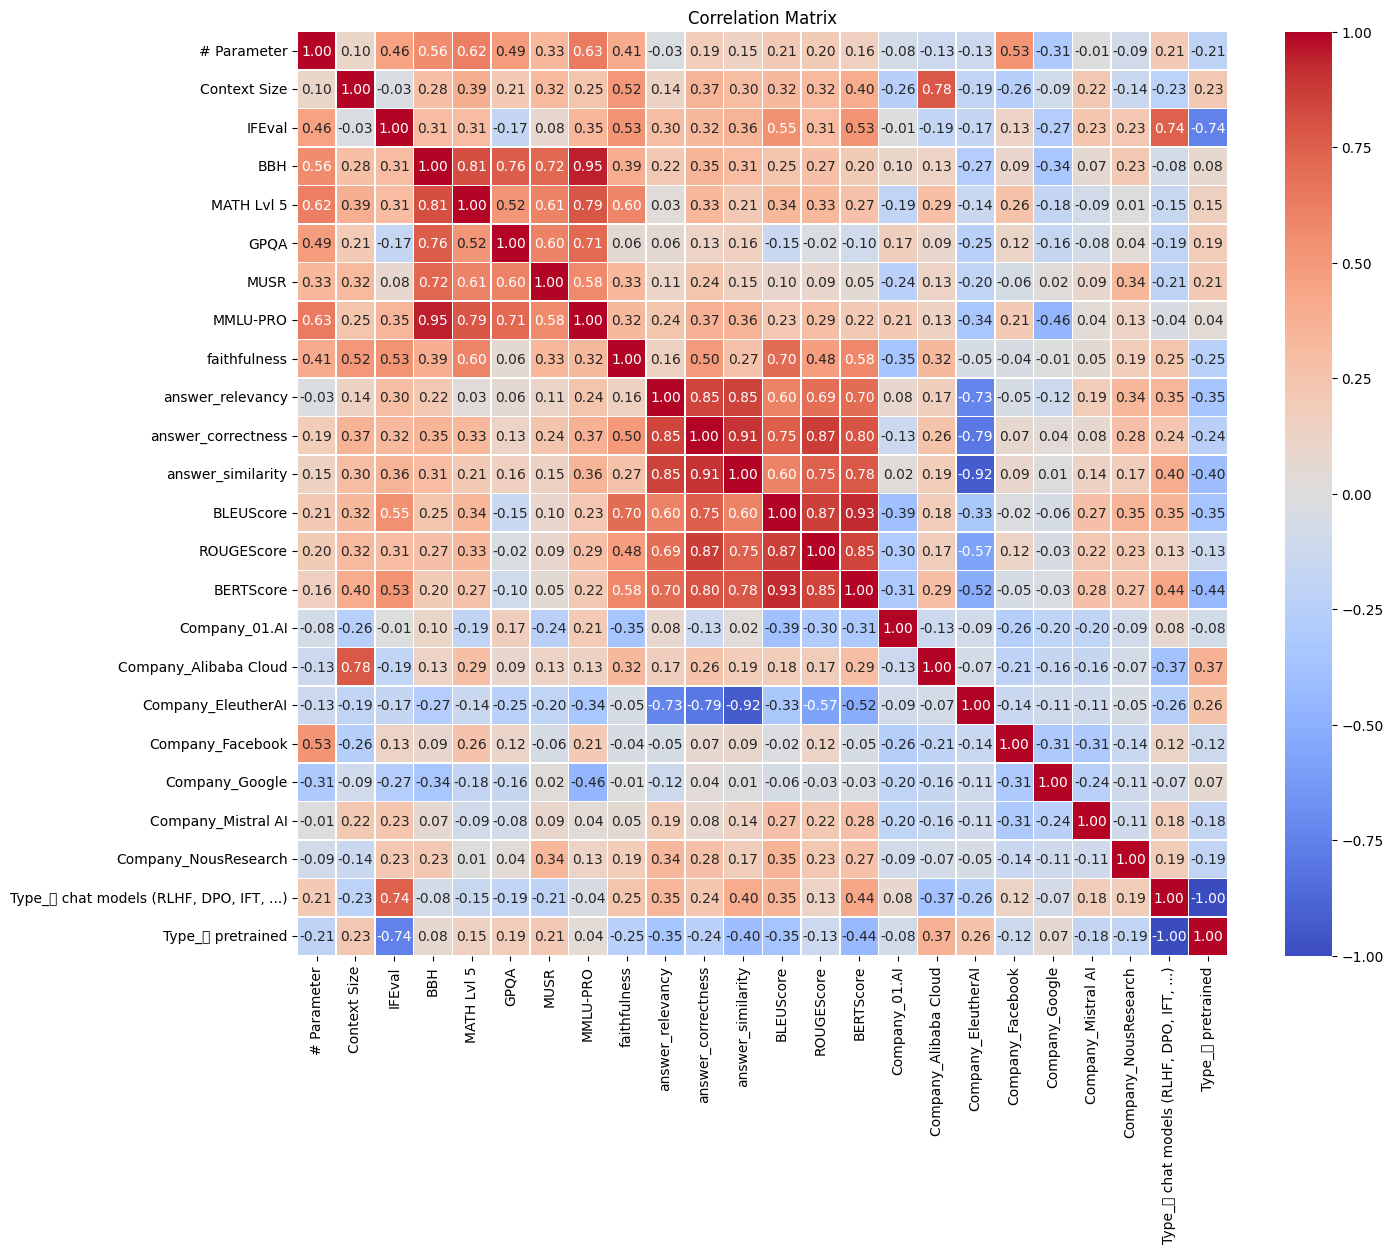

In [269]:
llm_values_corr = pd.get_dummies(new_df2).corr()

# Plotting the correlation matrix using seaborn
plt.figure(figsize=(15, 12))
sns.heatmap(llm_values_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [270]:
llm_values_corr

# Parameter  Context Size    IFEval  \
# Parameter                                  1.000000      0.102352  0.455166   
Context Size                                 0.102352      1.000000 -0.027644   
IFEval                                       0.455166     -0.027644  1.000000   
BBH                                          0.556792      0.283382  0.308716   
MATH Lvl 5                                   0.623057      0.390414  0.309464   
GPQA                                         0.486785      0.207807 -0.167875   
MUSR                                         0.329430      0.316171  0.080579   
MMLU-PRO                                     0.634758      0.247209  0.345985   
faithfulness                                 0.412590      0.515068  0.527651   
answer_relevancy                            -0.030111      0.140536  0.298676   
answer_correctness                           0.185616      0.367142  0.320815   
answer_similarity                            0.146118      0.301492  0.362587   
BLEUScore                                    0.212545      0.323437  0.545756   
ROUGEScore                                   0.196153      0.316911  0.309351   
BERTScore                                    0.160721      0.402693  0.527685   
Company_01.AI                               -0.077909     -0.255662 -0.007061   
Company_Alibaba Cloud                       -0.128278      0.776081 -0.185986   
Company_EleutherAI                          -0.130992     -0.188240 -0.167217   
Company_Facebook                             0.530582     -0.259718  0.130260   
Company_Google                              -0.314954     -0.094618 -0.272084   
Company_Mistral AI                          -0.012170      0.219114  0.234743   
Company_NousResearch                        -0.086517     -0.140032  0.227715   
Type_💬 chat models (RLHF, DPO, IFT, ...)     0.210065     -0.225235  0.743361   
Type_🟢 pretrained                           -0.210065      0.225235 -0.743361   

                                               BBH  MATH Lvl 5      GPQA  \
# Parameter                               0.556792    0.623057  0.486785   
Context Size                              0.283382    0.390414  0.207807   
IFEval                                    0.308716    0.309464 -0.167875   
BBH                                       1.000000    0.814686  0.762093   
MATH Lvl 5                                0.814686    1.000000  0.516257   
GPQA                                      0.762093    0.516257  1.000000   
MUSR                                      0.720315    0.608854  0.604151   
MMLU-PRO                                  0.952344    0.788766  0.714070   
faithfulness                              0.393331    0.598940  0.061681   
answer_relevancy                          0.222154    0.028908  0.059699   
answer_correctness                        0.353381    0.332909  0.131542   
answer_similarity                         0.308238    0.211859  0.160702   
BLEUScore                                 0.246097    0.340145 -0.145891   
ROUGEScore                                0.274218    0.329188 -0.024931   
BERTScore                                 0.200665    0.268963 -0.097427   
Company_01.AI                             0.102766   -0.192535  0.167320   
Company_Alibaba Cloud                     0.126632    0.287360  0.093639   
Company_EleutherAI                       -0.267235   -0.140445 -0.249149   
Company_Facebook                          0.094394    0.258963  0.115624   
Company_Google                           -0.341119   -0.178913 -0.157505   
Company_Mistral AI                        0.069142   -0.089258 -0.083814   
Company_NousResearch                      0.225086    0.005852  0.044836   
Type_💬 chat models (RLHF, DPO, IFT, ...) -0.076922   -0.151409 -0.192344   
Type_🟢 pretrained                         0.076922    0.151409  0.192344   

                                              MUSR  MMLU-PRO  faithfulness  \
# Parameter                          

In [271]:
top_portfolio

IFEval    BBH  MATH Lvl 5  GPQA   MUSR  MMLU-PRO  \
Model                                                                          
meta-llama-3-70b-instruct    80.99  50.19       23.34  4.92  10.92     46.74   
mixtral-8x7b-instruct-v0.1   53.95  34.02        9.06  7.61  12.11     29.36   
nous-hermes-2-solar-10.7b    52.79  34.99        5.21  5.82  13.83     27.31   
qwen1.5-14b                  29.05  30.06       16.47  5.93  10.46     29.37   

                                                           Type  faithfulness  \
Model                                                                           
meta-llama-3-70b-instruct   💬 chat models (RLHF, DPO, IFT, ...)      0.929193   
mixtral-8x7b-instruct-v0.1  💬 chat models (RLHF, DPO, IFT, ...)      0.833260   
nous-hermes-2-solar-10.7b   💬 chat models (RLHF, DPO, IFT, ...)      0.715556   
qwen1.5-14b                                        🟢 pretrained      0.809021   

                            answer_relevancy  answer_correctness  \
Model                                                              
meta-llama-3-70b-instruct           0.640306            0.434311   
mixtral-8x7b-instruct-v0.1          0.624648            0.403504   
nous-hermes-2-solar-10.7b           0.845074            0.477079   
qwen1.5-14b                         0.691472            0.439554   

                            answer_similarity  BLEUScore  ROUGEScore  \
Model                                                                  
meta-llama-3-70b-instruct            0.834571   0.187447    0.396808   
mixtral-8x7b-instruct-v0.1           0.822645   0.135882    0.344774   
nous-hermes-2-solar-10.7b            0.864949   0.178626    0.378722   
qwen1.5-14b                          0.830944   0.111765    0.325026   

                            BERTScore  
Model                                  
meta-llama-3-70b-instruct    0.890205  
mixtral-8x7b-instruct-v0.1   0.878854  
nous-hermes-2-solar-10.7b    0.890395  
qwen1.5-14b                  0.882078

In [272]:
new_df2

Company  # Parameter  Context Size  IFEval  \
Model                                                                          
meta-llama-3-70b-instruct        Facebook         70.0           8.0   80.99   
meta-llama-3-8b                  Facebook          8.0           8.0   14.55   
mixtral-8x7b-instruct-v0.1     Mistral AI         56.0          32.0   53.95   
llama-2-7b-chat                  Facebook          7.0           4.0   39.65   
llama-2-70b-chat                 Facebook         70.0           4.0   49.58   
llama-2-13b-chat                 Facebook         13.0           4.0   39.85   
mistral-7b-instruct-v0.2       Mistral AI          7.0           8.0   54.96   
mistral-7b-v0.1                Mistral AI          7.0           8.0   23.86   
mistral-7b-instruct-v0.1       Mistral AI          7.0           8.0   45.02   
meta-llama-3-70b                 Facebook         70.0           8.0   16.03   
yi-34b-chat                         01.AI         34.0           4.0   46.99   
yi-6b                               01.AI          6.0           4.0   28.93   
gemma-2b-it                        Google          2.0           8.0   26.90   
gemma-7b-it                        Google          7.0           8.0   38.68   
nous-hermes-2-solar-10.7b    NousResearch         10.7           4.0   52.79   
gpt-j-6b                       EleutherAI          6.0           2.0   25.22   
gemma-7b                           Google          7.0           8.0   26.59   
yi-6b-chat                          01.AI          6.0           4.0   33.95   
gemma-2b                           Google          2.0           8.0   20.38   
qwen1.5-14b                 Alibaba Cloud         14.0          32.0   29.05   
qwen1.5-7b                  Alibaba Cloud          7.0          32.0   26.84   

                              BBH  MATH Lvl 5   GPQA   MUSR  MMLU-PRO  \
Model                                                                   
meta-llama-3-70b-instruct   50.19       23.34   4.92  10.92     46.74   
meta-llama-3-8b             24.50        3.25   7.38   6.24     24.55   
mixtral-8x7b-instruct-v0.1  34.02        9.06   7.61  12.11     29.36   
llama-2-7b-chat              4.49        0.68   0.56   3.48      7.52   
llama-2-70b-chat             4.61        0.91   1.90   3.48     15.92   
llama-2-13b-chat             7.16        0.60   0.00   8.16     10.26   
mistral-7b-instruct-v0.2    22.91        2.64   3.47   7.61     19.08   
mistral-7b-v0.1             22.02        2.49   5.59  10.68     22.36   
mistral-7b-instruct-v0.1    13.79        1.51   0.00   5.77     15.34   
meta-llama-3-70b            48.71       16.54  19.69  16.01     41.21   
yi-34b-chat                 37.62        4.31  11.74   8.36     34.37   
yi-6b                       19.41        1.51   2.57   7.04     22.12   
gemma-2b-it                  5.21        0.45   3.80   3.03      3.92   
gemma-7b-it                 11.94        1.59   4.59  12.53      7.72   
nous-hermes-2-solar-10.7b   34.99        5.21   5.82  13.83     27.31   
gpt-j-6b                     4.91        1.21   0.00   5.25      2.68   
gemma-7b                    21.12        6.42   4.92  10.98     21.64   
yi-6b-chat                  17.00        0.68   5.93   3.57     22.90   
gemma-2b                     8.25        2.72   0.67   7.56      4.06   
qwen1.5-14b                 30.06       16.47   5.93  10.46     29.37   
qwen1.5-7b                  23.08        4.46   6.49   9.16     21.29   

                                                           Type  faithfulness  \
Model                                                                           
meta-llama-3-70b-instruct   💬 chat models (RLHF, DPO, IFT, ...)      0.929193   
meta-llama-3-8b                                    🟢 pretrained      0.436381   
mixtral-8x7b-instruct-v0.1  💬 chat models (RLHF, DPO, IFT, ...)      0.833260   
llama-2-7b-chat             💬 chat models (RLHF, DPO, IFT, ...)      0.447794   
llama-2-70b-chat           

In [257]:
new_df2.columns

Index(['Company', '# Parameter', 'Context Size', 'IFEval', 'BBH', 'MATH Lvl 5',
       'GPQA', 'MUSR', 'MMLU-PRO', 'Type', 'faithfulness', 'answer_relevancy',
       'answer_correctness', 'answer_similarity', 'BLEUScore', 'ROUGEScore',
       'BERTScore'],
      dtype='object')

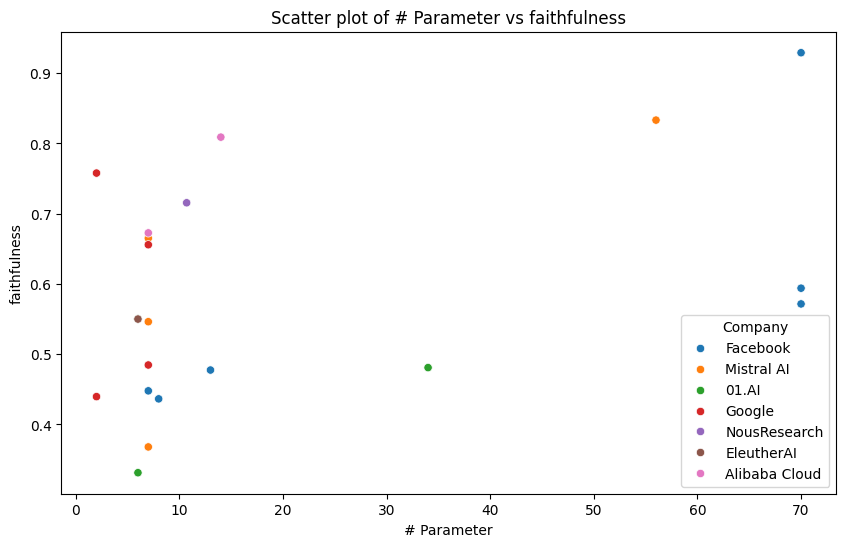

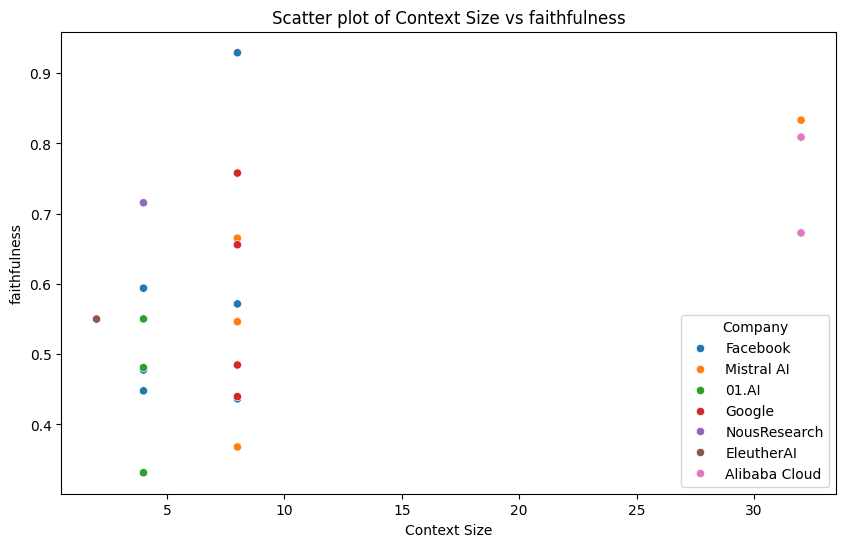

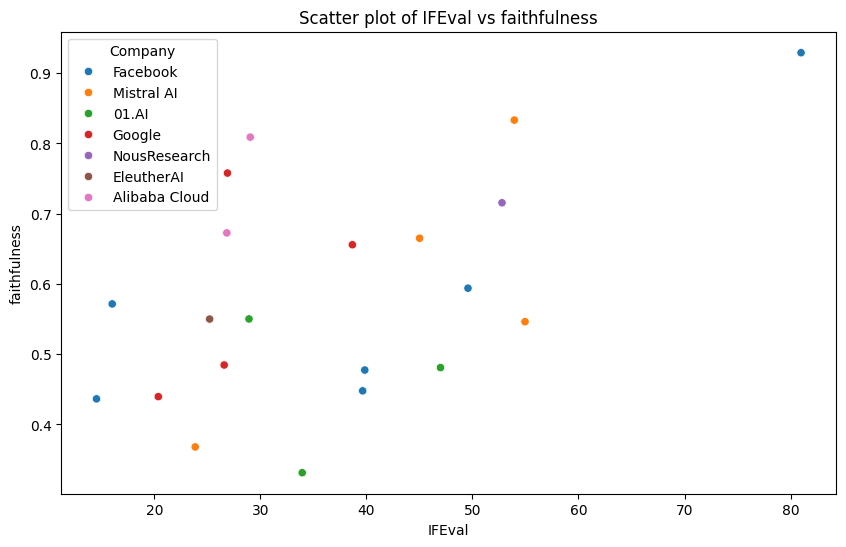

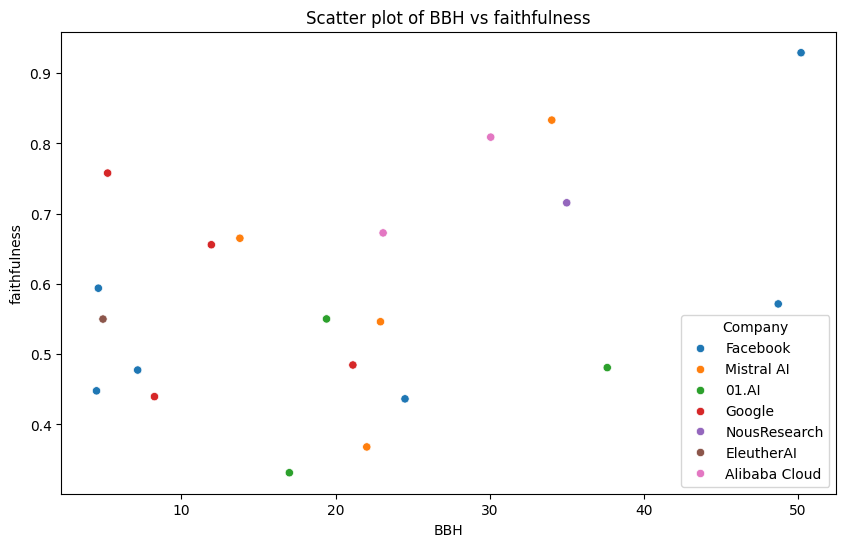

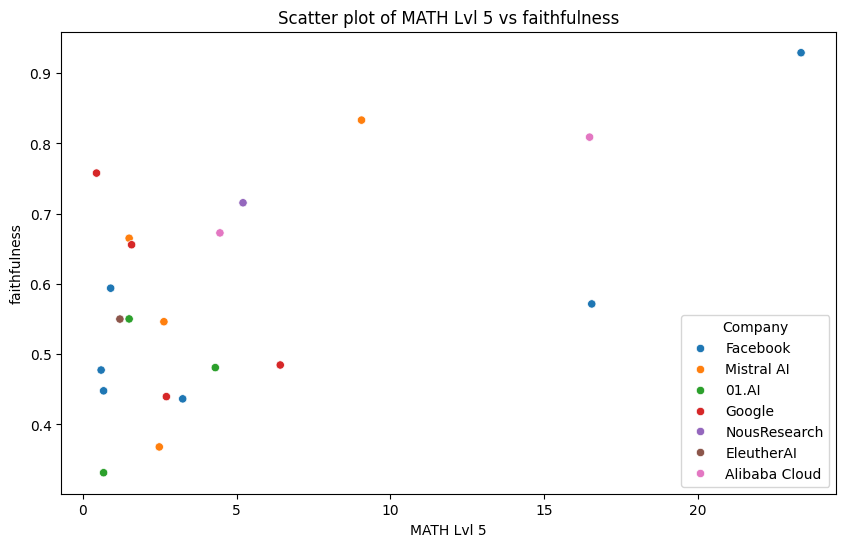

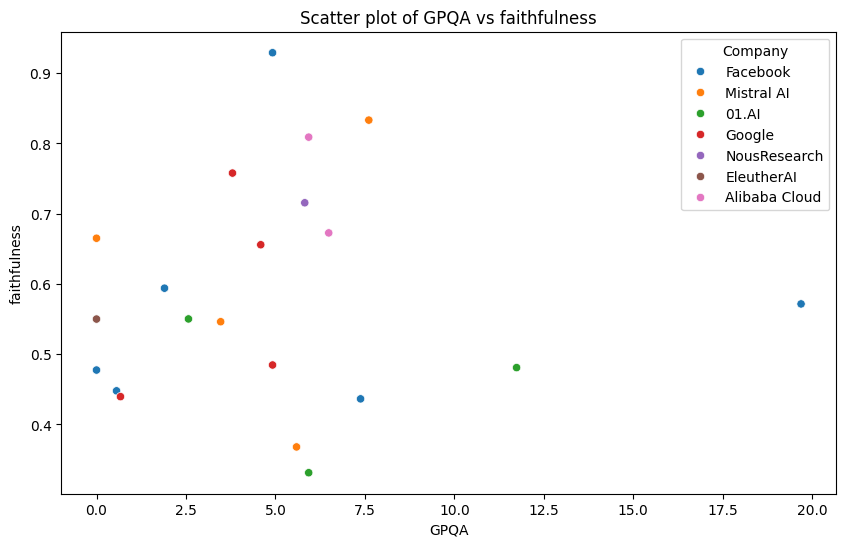

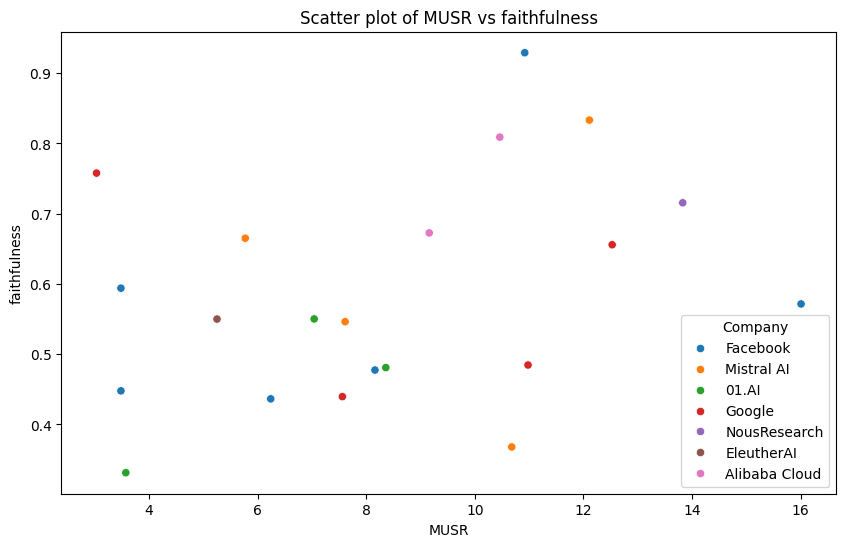

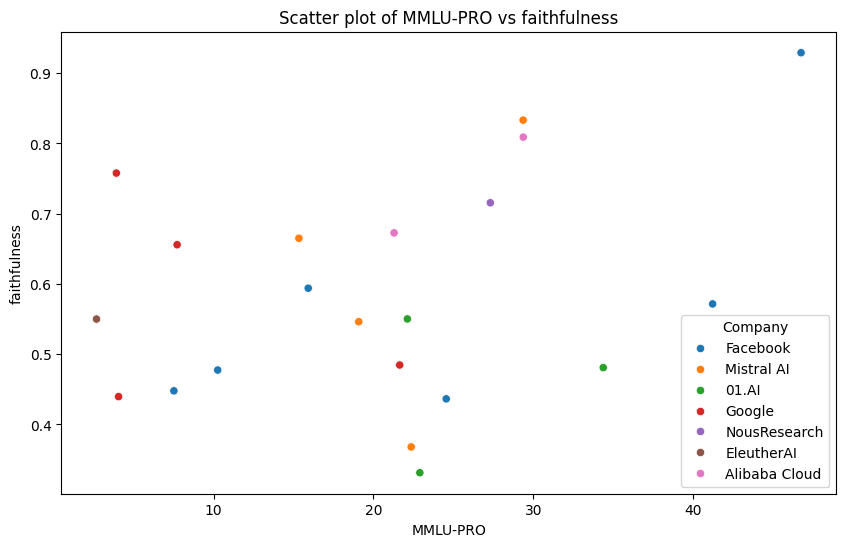

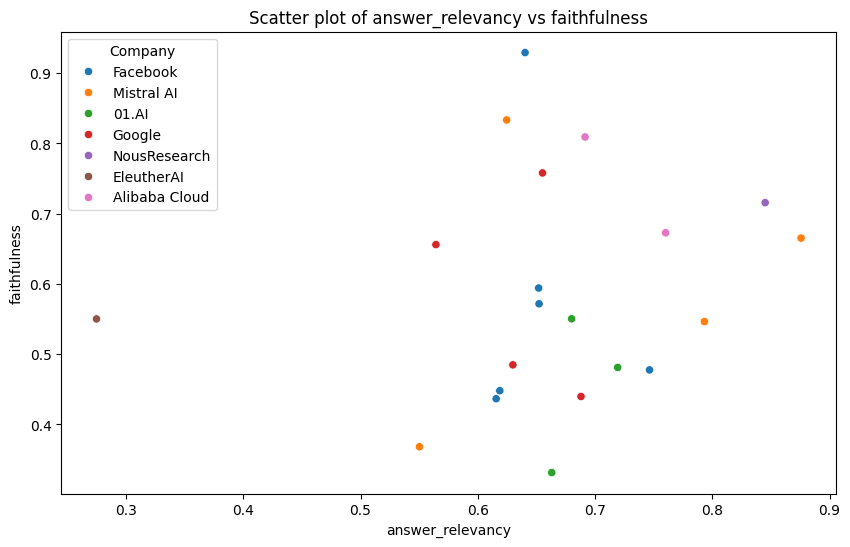

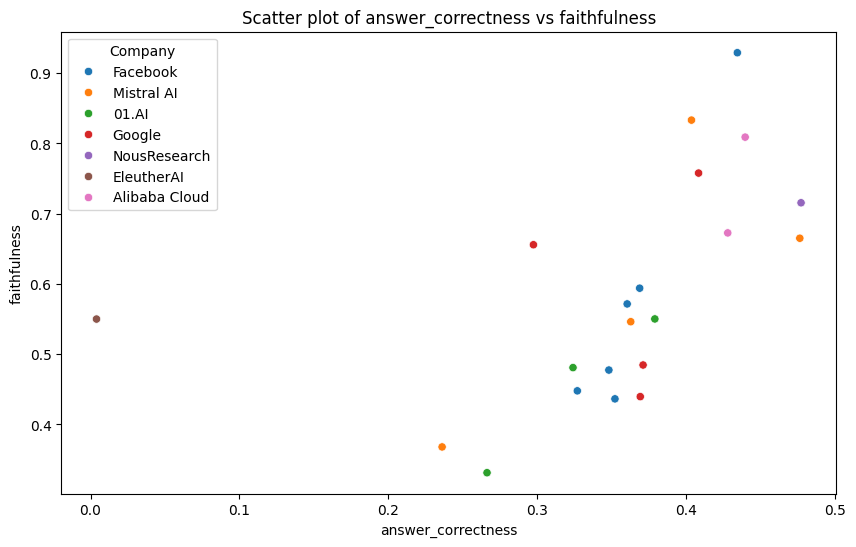

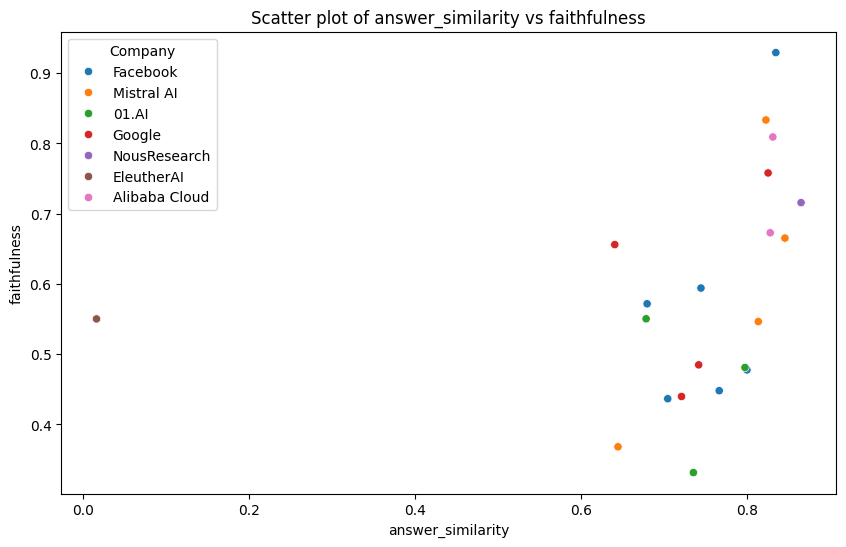

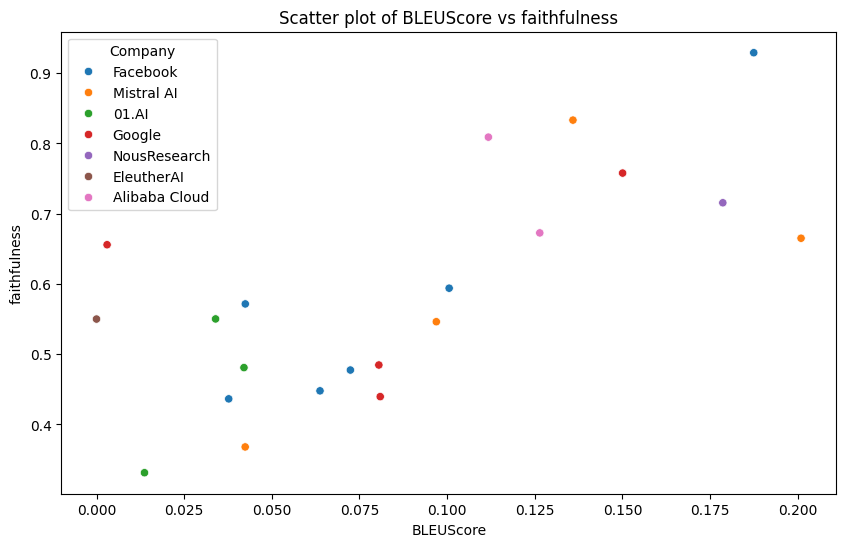

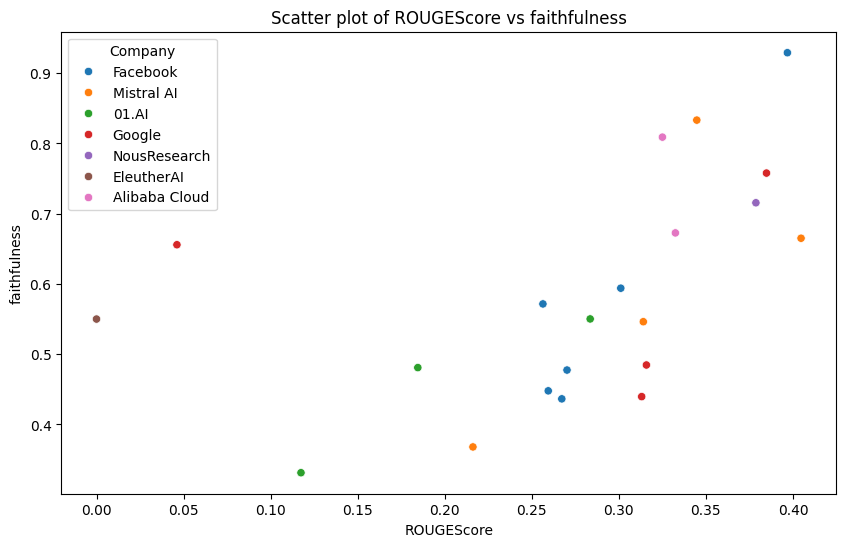

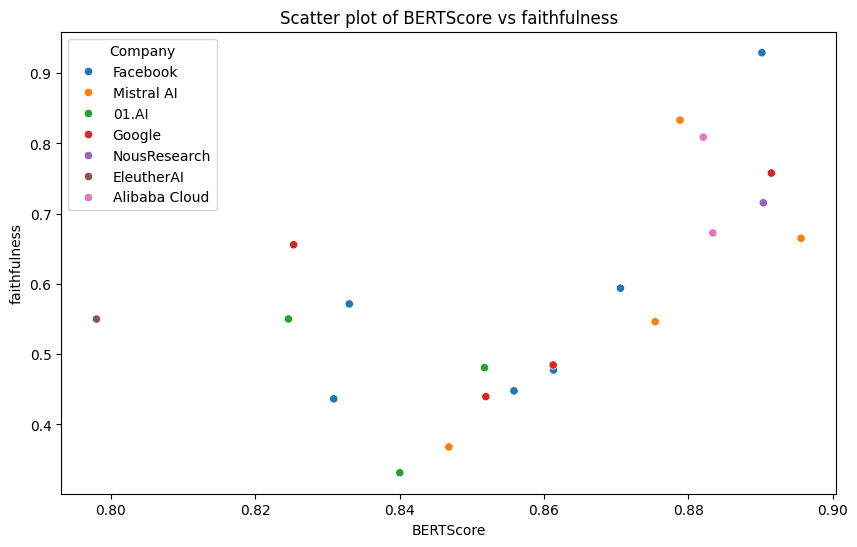

In [258]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Assuming the dataframe is named df
df = new_df2#pd.read_csv('your_dataset.csv')  # Replace with your actual CSV file path

# Identify continuous columns and faithfulness column
continuous_columns = ['# Parameter', 'Context Size', 'IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO', 'answer_relevancy', 'answer_correctness', 'answer_similarity', 'BLEUScore', 'ROUGEScore',
       'BERTScore']
faithfulness_column = 'faithfulness'
company_column = 'Company'

# Generate scatter plots
for col in continuous_columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=col, y=faithfulness_column, hue=company_column, palette='tab10')
    plt.title(f'Scatter plot of {col} vs {faithfulness_column}')
    plt.xlabel(col)
    plt.ylabel(faithfulness_column)
    plt.legend(title=company_column)
    plt.show()


In [263]:
new_df2.columns

Index(['Company', '# Parameter', 'Context Size', 'Type', 'faithfulness',
       'answer_relevancy', 'answer_correctness', 'answer_similarity',
       'BLEUScore', 'ROUGEScore', 'BERTScore'],
      dtype='object')

In [261]:
new_df2.columns
new_df2.drop(['IFEval', 'BBH', 'MATH Lvl 5',
       'GPQA', 'MUSR', 'MMLU-PRO'], axis=1,inplace=True)

In [264]:
new_df2.drop(['faithfulness',
       'answer_relevancy', 'answer_correctness', 'answer_similarity',
       'BLEUScore', 'ROUGEScore', 'BERTScore'], axis=1,inplace=True)

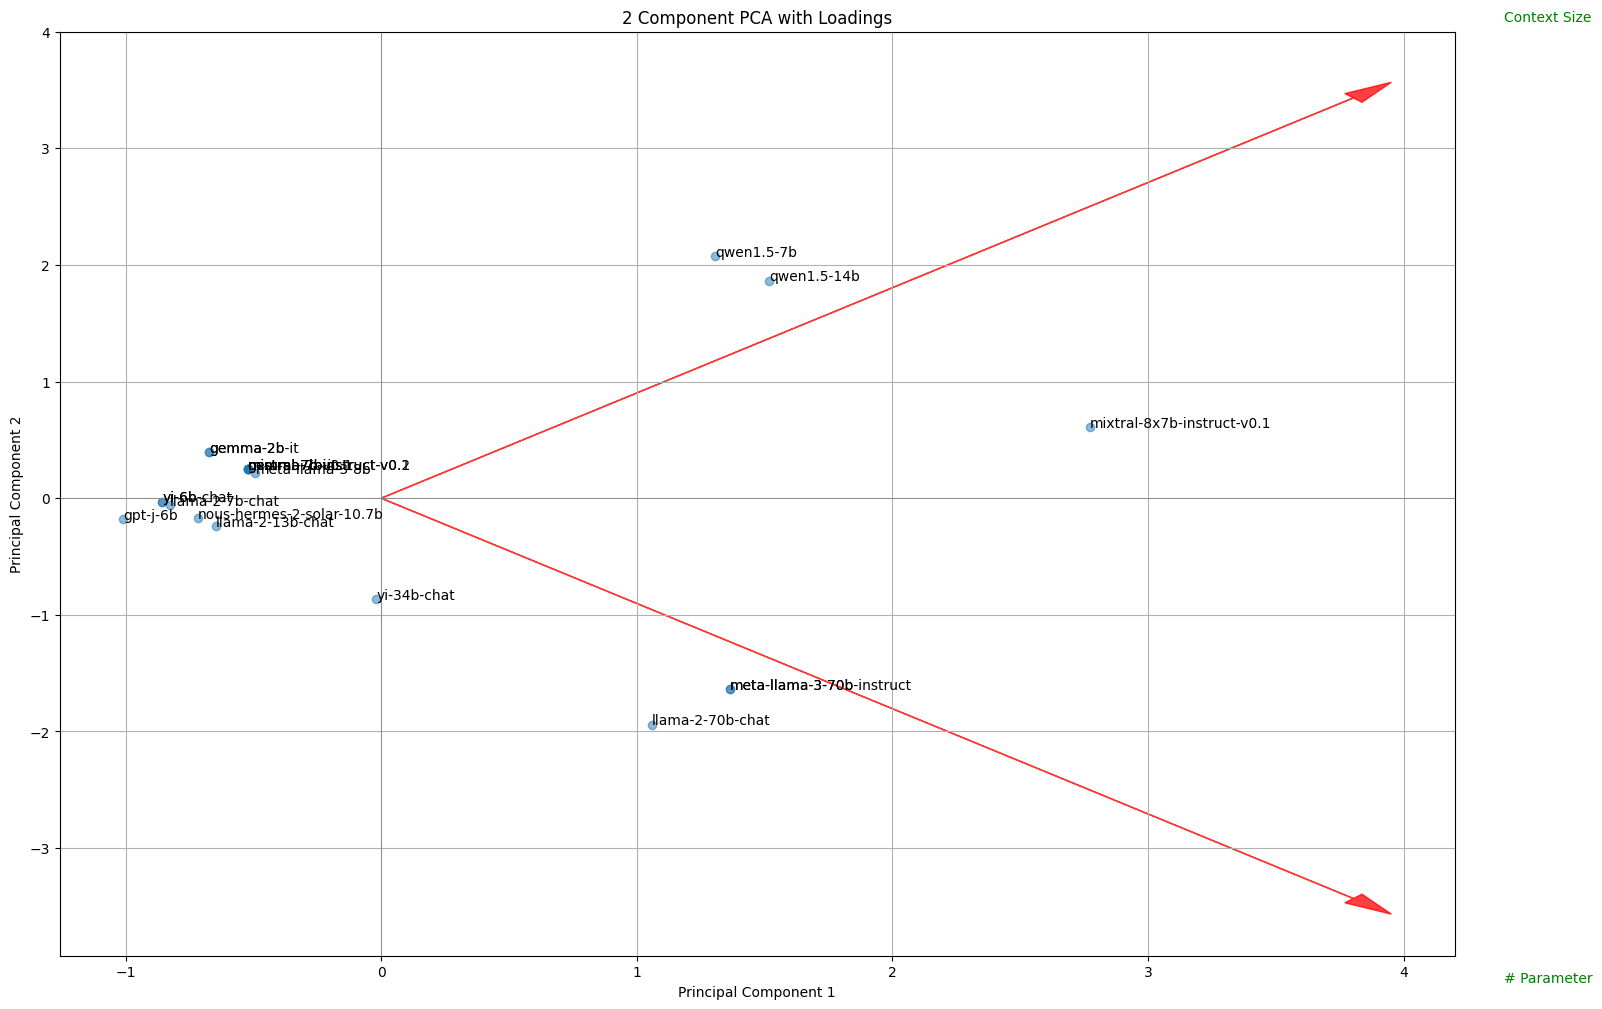

   Explained Variance
0            0.551176
1            0.448824


In [265]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assume `data` is your dataframe loaded from a CSV or created manually from the provided image

# Drop any non-numeric columns for PCA
numeric_data = new_df2.select_dtypes(include=[float, int])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply PCA with 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the 2 principal components
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'], index=numeric_data.index)

# Plot the 2 principal components
plt.figure(figsize=(18, 12))
plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], alpha=0.5)

# Annotate each point with its index
for i in principal_df.index:
    plt.annotate(i, (principal_df.loc[i, 'Principal Component 1'], principal_df.loc[i, 'Principal Component 2']))

# Plot the loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
scaling_factor = 5  # Increase this factor to make the lines longer
for i, (x, y) in enumerate(zip(loadings[:, 0], loadings[:, 1])):
    plt.arrow(0, 0, x * scaling_factor, y * scaling_factor, color='r', alpha=0.75, head_width=0.1, head_length=0.2)
    plt.text(x * scaling_factor * 1.2, y * scaling_factor * 1.2, numeric_data.columns[i], color='g', ha='center', va='center')

plt.title('2 Component PCA with Loadings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Set custom ticks on the Y-axis
y_ticks = np.arange(-3, 4.5, 1)  # Example: from -10 to 10 with step 2
plt.yticks(y_ticks)

plt.grid()
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.show()

# Show the explained variance by the 2 components
explained_variance = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])

print(explained_variance_df)